## Imports and Defs

In [1]:
! git clone 'https://github.com/PeterF1234/photocatalyst-TDDFT-benchmark/' # if using Google Colab

Cloning into 'photocatalyst-TDDFT-benchmark'...
remote: Enumerating objects: 1041, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 1041 (delta 90), reused 126 (delta 81), pack-reused 896
Receiving objects: 100% (1041/1041), 199.65 MiB | 10.71 MiB/s, done.
Resolving deltas: 100% (472/472), done.
Checking out files: 100% (666/666), done.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def get_percentages(errors, df_, group_by="functional"):
  # errors --> max_counts == df["size"], df_ --> actual_counts == df["counts"]
  max_counts = errors.groupby(group_by, as_index=False).size()
  df = df_.merge(max_counts, how="outer")
  df["percentage_count"] = df["counts"] / df["size"] * 100 # counts is from df_, size is from max_counts
  df.drop(columns=["size"], inplace=True)
  return df

def get_region(errors, region, group_by="functional", percentages=True):
  if region == "wide":
    rgn_ = errors.query("bandwidth > 0.35").copy()
  elif region in ("10%","tenpercent","ten_percent"):
    rgn_ = errors.query("(shift_factor <= 1.1) and (shift_factor >= 0.9)").copy()
  elif region in ("optimal","opt"):
    rgn_ = errors.query("(shift_factor < 1.2) and (shift_factor > 0.8) and (bandwidth < 0.30)").copy()
  elif region in ("above_10%","above_tenpercent","above_ten_percent"):
    rgn_ = errors.query("shift_factor > 1.1").copy()
  elif region in ("below_10%","below_tenpercent","below_ten_percent"):
    rgn_ = errors.query("shift_factor < 0.9").copy()
  else:
    return "Please provide a valid region!"
  rgn = rgn_.groupby(group_by, as_index=False).size()
  rgn.rename(columns={"size": "counts"}, inplace=True)
  if percentages == True:
    rgn = get_percentages(errors, rgn, group_by)
  else:
      for i in errors[group_by].unique():
        if i not in rgn[group_by].unique():
          rgn = pd.concat([rgn,pd.DataFrame({group_by:[i],"counts":0})], ignore_index=True)
  return rgn

def convert_error_names(errors):
    # errors['error_function'].replace({'r_square': '$r^2$', 'R2': '$R^2$'},inplace=True)
    errors['error_function'].replace({'mae': 'MAE', 'mse': 'MSE', 'rmsle': 'RMSLE', 'r_square': '$r^2$', 'R2': '$R^2$'},inplace=True)

def get_errors_db(full_db, error_type='mse'):
  pred = fulldb[fulldb['reference'] == 'no']
  pred = pred[pred["error_function"].isin([error_type])]
  pred = pred.astype({'shift_factor': 'float64', 'bandwidth': 'float64'})
  errors = pred.drop(columns=["reference","error_function","Wavelength [nm]","Intensity [a.u.]"]).drop_duplicates().reset_index(drop=True).copy()
  return errors # this is the database without the spectral data

def get_fulldb(db_loc):
  if '.gz' in db_loc:
    df = pd.read_csv(db_loc, header=0, compression='gzip')
  else:
    df = pd.read_csv(db_loc, header=0)
  df['functional'].replace({'STEOM-DLPNO-CCSD':'DLPNO-CCSD'},inplace=True)
  df['functional'].replace({'HF':'TDHF'},inplace=True)
  df['functional'].replace({'PBE-D3':'PBE'},inplace=True)
  df['functional'].replace({'B3LYP-D3':'B3LYP'},inplace=True)
  df['functional'].replace({'CAM-B3LYP-D3':'CAM-B3LYP'},inplace=True)
  df['molecule'].replace({'POZ_3':'POZ_2', 'PA_3':'PA_2'},inplace=True)
  df['molecule'].replace({'POZ_4':'POZ_3'},inplace=True)
  df['molecule'].replace({'POZ_5':'POZ_4'},inplace=True)
  return df

def get_lowestLambdas(fname):
  if fname[-4:] == '.csv':
    df = pd.read_csv(fname, header=0)
  elif fname[-4:] == '.xls' or fname[-4:] == 'xlsx':
    df = pd.read_excel(fname, header=0)
  df['functional'].replace({'STEOM-DLPNO-CCSD':'DLPNO-CCSD'},inplace=True)
  df['functional'].replace({'HF':'TDHF'},inplace=True)
  return df


## Set up initial databases and some variables for colors, etc.

In [4]:
# setup plot styles
plt.style.use("seaborn-paper")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 1.75,"axes.linewidth": 1.75,'xtick.major.width': 1.6,'ytick.major.width': 1.6})

In [5]:
# db_loc = "OPC_database.csv.gz" # modify this if using different database file
db_loc = "/content/photocatalyst-TDDFT-benchmark/for_analysis/OPC_database_20221115.csv.gz" # if using Google Colab and git clone
fulldb = get_fulldb(db_loc)
expt = fulldb[fulldb['reference'] == 'yes']
expt = expt.drop(columns=["reference","functional","error_function","error_value","bandwidth","shift_factor"])

In [6]:
c10 = "teal" # 'royalblue'
cOpt = "darkorchid" # 'seagreen'
cWide = "coral" # 'orangered'
regionColors = [c10, cOpt, cWide]

## Mean errors

In [7]:
pred = fulldb[fulldb['reference'] == 'no']
pred = pred[pred["error_function"].isin(["mae","mse","r_square","rmsle","R2"])] # skip the '-' entry
errors = pred.drop(columns=["reference","Wavelength [nm]","Intensity [a.u.]"])
errors.drop_duplicates(inplace=True) # this is the computational database without the spectral data
errors = errors.astype({'error_value': 'float64','bandwidth': 'float64','shift_factor': 'float64'})

In [8]:
# mseErrors = errors.query(f"error_function == 'MSE'").groupby("functional",as_index=False).mean().sort_values(by="error_value",ignore_index=True)
# mse_order = mseErrors.functional.unique() # order of functionals given by MSE

In [9]:
mse_order = errors.query(f"error_function == 'mse'").groupby("functional",as_index=False).mean().sort_values(by="error_value",ignore_index=True).functional.unique()
mse_order

array(['SCS-PBE-QIDH', '$\\omega$-PBEPP86', 'B2PLYP', '$\\omega$-B2PLYP',
       'B2GP-PLYP', 'CAM-B3LYP', 'M062X', '$\\omega$-B97XD', 'M06',
       'DLPNO-CCSD', 'B3LYP', 'M06L', 'TPSS', 'B97D3', 'PBE', 'DSD-BLYP',
       'TDHF'], dtype=object)

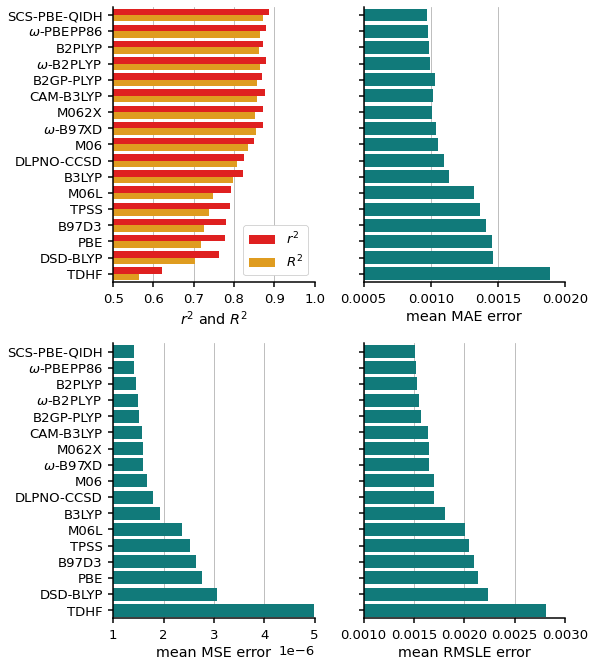

In [10]:
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

pred = fulldb[fulldb['reference'] == 'no']
pred = pred[pred["error_function"].isin(["mae","mse","r_square","rmsle","R2"])] # skip the '-' entry
errors = pred.drop(columns=["reference","Wavelength [nm]","Intensity [a.u.]"])
errors.drop_duplicates(inplace=True) # this is the computational database without the spectral data
errors = errors.astype({'error_value': 'float64','bandwidth': 'float64','shift_factor': 'float64'})

convert_error_names(errors)

qq_ = errors.query(f"error_function == '$r^2$'").groupby("functional",as_index=False).mean().sort_values(by="error_value",ascending=False,ignore_index=True)
qq = qq_.drop(columns=["bandwidth","shift_factor"]).rename(columns={"error_value": '$r^2$'})
ww_ = errors.query(f"error_function == '$R^2$'").groupby("functional",as_index=False).mean().sort_values(by="error_value",ascending=False,ignore_index=True)
ww = ww_.drop(columns=["bandwidth","shift_factor"]).rename(columns={"error_value": '$R^2$'})
q_ = qq.merge(ww)
q = pd.melt(q_, id_vars=["functional"], value_vars=[r'$r^2$',r'$R^2$'], var_name="error", value_name='error_value')

fsize = (8.5,9.5)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=fsize)

n = 0
efs = ['r',"MAE","MSE","RMSLE"]
for i, ax in enumerate(fig.axes):
  ef = efs[n]
  if ef == 'r':
    palette = ['red','orange']
    sns.barplot(data=q, x="error_value", y="functional", hue="error", palette=palette, ax=ax, order=mse_order)
    ax.set(xlabel=r'$r^2$ and $R^2$', ylabel=None, xlim=[0.5,1])
    loc_ = 'lower right' # 'best'
    ax.legend(frameon=True, title=None, loc=loc_, facecolor="white", framealpha=1)
  else:
    sub_db = errors.query(f"error_function == '{ef}'").groupby("functional",as_index=False).mean().sort_values(by="error_value",ignore_index=True)
    sns.barplot(data=sub_db, x="error_value", y="functional",ax=ax, color="darkcyan", order=mse_order).set(xlabel=f'mean {ef} error', ylabel=None)
    if ef == "MSE":
      ax.set_xlim(1e-6, 5e-6)
    elif ef == "MAE":
      ax.set_xlim(0.0005, 0.002)
    elif ef == "RMSLE":
      ax.set_xlim(0.0010, 0.003)
    if i in (1,3):
      ax.set_yticklabels([])
  ax.grid(axis = 'x')
  ax.set_axisbelow(True)
  n += 1
sns.despine()
plt.tight_layout()
plt.savefig('five_errors.png', dpi=200, bbox_inches='tight', pad_inches=0)

## Alpha and delta distributions

In [11]:
errors = get_errors_db(fulldb, error_type='mse')
# fulldb.equals(get_fulldb(db_loc)) # for testing

Calculate the MSE means and the corresponding standard errors (sem) for all functionals, then sort them by the means.

> Note: the values are multiplied by 10<sup>6</sup> for clarity

In [12]:
mseonly = errors.get(["functional","error_value"]).astype({'error_value': 'float64'}).copy()
mseonly["error_value"] = mseonly["error_value"] * 1e6
mse_means = mseonly.groupby("functional", as_index=False).mean().rename(columns={"error_value":"mse_mean"})
mse_sem = mseonly.groupby("functional", as_index=False).sem().rename(columns={"error_value":"mse_sem"}) # standard error of the mean
mse_means_ = mse_means.merge(mse_sem)
mse_means_['functional'] = pd.Categorical(mse_means_['functional'],categories=mse_order,ordered=True)
mse_means_ = mse_means_.sort_values(['functional'], ignore_index=True).round(2)

Now calculate the means and sems for the optimized bandwidths and scaling factors.

In [13]:
bw_means = errors.get(["functional","bandwidth"]).groupby("functional", as_index=False).mean().rename(columns={"bandwidth":"bandwidth_mean"})
bw_sem = errors.get(["functional","bandwidth"]).groupby("functional", as_index=False).sem().rename(columns={"bandwidth":"bandwidth_sem"}) # standard error of the mean
bw_means_ = bw_means.merge(bw_sem)
bw_means_['functional'] = pd.Categorical(bw_means_['functional'],categories=mse_order,ordered=True)
bw_means_ = bw_means_.sort_values(['functional'], ignore_index=True).round(2)

In [14]:
sf_means = errors.get(["functional","shift_factor"]).groupby("functional", as_index=False).mean().rename(columns={"shift_factor":"shift_factor_mean"})
sf_sem = errors.get(["functional","shift_factor"]).groupby("functional", as_index=False).sem().rename(columns={"shift_factor":"shift_factor_sem"}) # standard error of the mean
sf_means_ = sf_means.merge(sf_sem)
sf_means_['functional'] = pd.Categorical(sf_means_['functional'],categories=mse_order,ordered=True)
sf_means_ = sf_means_.sort_values(['functional'], ignore_index=True).round(2)

Tabulate the results in nice format and save the data to a csv file.

In [15]:
mse_means_['err_mean'] = mse_means_['mse_mean'].apply("{:.02f}".format) + ' (±' + mse_means_["mse_sem"].apply("{:.02f}".format) + ')'
bw_means_['bw_mean'] = bw_means_['bandwidth_mean'].apply("{:.02f}".format) + ' (±' + bw_means_["bandwidth_sem"].apply("{:.02f}".format) + ')'
sf_means_['sf_mean'] = sf_means_['shift_factor_mean'].apply("{:.02f}".format) + ' (±' + sf_means_["shift_factor_sem"].apply("{:.02f}".format) + ')'
mse_means_result = mse_means_.get(["functional","err_mean"]).merge(sf_means_.get(["functional","sf_mean"])).merge(bw_means_.get(["functional","bw_mean"]))
# err_mean is the MSE error x 1e6 !!!
mse_means_result.to_csv("mse_means_result.csv", index=False)
mse_means_result

functional      err_mean       sf_mean       bw_mean
0       SCS-PBE-QIDH  1.41 (±0.20)  1.02 (±0.01)  0.21 (±0.02)
1   $\omega$-PBEPP86  1.42 (±0.19)  1.06 (±0.01)  0.20 (±0.01)
2             B2PLYP  1.45 (±0.20)  0.99 (±0.01)  0.21 (±0.01)
3    $\omega$-B2PLYP  1.48 (±0.20)  1.12 (±0.01)  0.21 (±0.02)
4          B2GP-PLYP  1.52 (±0.20)  1.03 (±0.01)  0.20 (±0.01)
5          CAM-B3LYP  1.57 (±0.19)  1.12 (±0.02)  0.21 (±0.02)
6              M062X  1.58 (±0.19)  1.12 (±0.02)  0.21 (±0.02)
7     $\omega$-B97XD  1.59 (±0.19)  1.14 (±0.02)  0.22 (±0.02)
8                M06  1.67 (±0.18)  1.02 (±0.02)  0.20 (±0.01)
9         DLPNO-CCSD  1.80 (±0.30)  0.98 (±0.01)  0.21 (±0.02)
10             B3LYP  1.93 (±0.21)  0.99 (±0.02)  0.23 (±0.02)
11              M06L  2.37 (±0.28)  0.91 (±0.03)  0.27 (±0.02)
12              TPSS  2.52 (±0.32)  0.89 (±0.03)  0.27 (±0.02)
13             B97D3  2.64 (±0.34)  0.87 (±0.03)  0.27 (±0.02)
14               PBE  2.76 (±0.36)  0.89 (±0.03)  0.27 (±0.02)
15          DSD-BLYP  3.05 (±0.45)  0.90 (±0.03)  0.21 (±0.02)
16              TDHF  4.99 (±0.82)  1.27 (±0.01)  0.35 (±0.02)

Plot the 2D histogram (with kernel density estimation for smoothing) of the distribution of the bandwidth and scale factor parameters using the MSE data. 
- We use with kernel density estimation for smoothing and contour lines for visualization. 
- We also set up three regions (10%, optimal, wide) and count the number of occurrences of each functional in these regions.

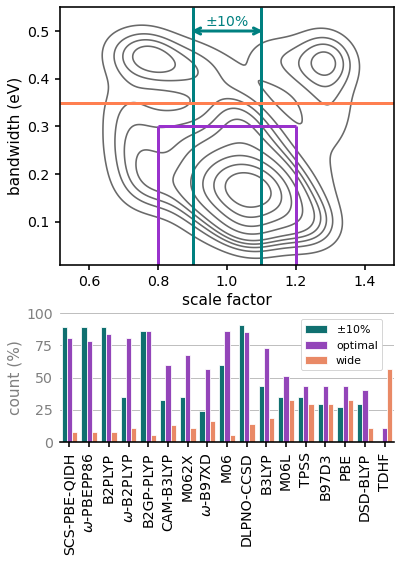

In [16]:
wide_errors_functionals = get_region(errors, "wide", group_by="functional", percentages=True)
optimal_functionals = get_region(errors, "optimal", group_by="functional", percentages=True)
tenpercent_functionals = get_region(errors, "10%", group_by="functional", percentages=True)

wides_ = wide_errors_functionals.rename(columns={"percentage_count":"wide"}).drop(columns=["counts"])
optimals_ = optimal_functionals.rename(columns={"percentage_count":"optimal"}).drop(columns=["counts"])
tenpercents_ = tenpercent_functionals.rename(columns={"percentage_count":r'$\pm$10%'}).drop(columns=["counts"])

# tenpercents_.merge(optimals_, how="outer").merge(wides_, how="outer")
hits_grouped_ = tenpercents_.merge(optimals_, how="outer").merge(wides_, how="outer")
hits_grouped = pd.melt(hits_grouped_, id_vars="functional", value_vars=[r'$\pm$10%',"optimal","wide"], var_name="region", value_name="count_percentage")


scale=1.6
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

# Set up the grid
fig = plt.figure(figsize=(6,8))
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0.25)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# ax1 -- 2D histogram
sns.kdeplot(data=errors, x="shift_factor", y="bandwidth",ax=ax1, color="dimgrey") # linestyles="--"
# sns.despine()
ax1.set_ylim(0.01,0.55)
ax1.set_xlim(0.514, 1.486)
ax1.vlines(x = 0.9, ymin = 0.01, ymax = 0.55,colors = c10,lw=3)
ax1.vlines(x = 1.1, ymin = 0.01, ymax = 0.55,colors = c10,lw=3)
ax1.vlines(x = 0.8, ymin = 0.01, ymax = 0.3,colors = cOpt,lw=3)
ax1.vlines(x = 1.2, ymin = 0.01, ymax = 0.3,colors = cOpt,lw=3)
ax1.hlines(y=0.3, xmin=0.8, xmax=1.2, color=cOpt, lw=3, )
ax1.hlines(y=0.35, xmin=0.514, xmax=1.486, color=cWide, lw=3)
ax1.annotate("",(0.89,0.5), (1.11,0.5), color=c10, arrowprops={'arrowstyle': '<->','lw':3,'facecolor':c10,'edgecolor':c10})
ax1.annotate(r'$\pm$10%',xy=(1.0,0.52),xytext=(0.935,0.51),color=c10,size=14)
ax1.set_xlabel('scale factor')
ax1.set_ylabel('bandwidth (eV)')

# ax2 -- bar plot
sns.barplot(ax=ax2,y="count_percentage", x="functional", data=hits_grouped, hue="region", palette=regionColors, order=mse_order, edgecolor="white")
ax2.legend(frameon=True, title=False, fontsize=11, facecolor="white", framealpha=1, loc='upper right', bbox_to_anchor=(0.98, 1.))
# loc='upper right', bbox_to_anchor=(0.98, 1.) --> put the legend's upper right-hand corner to the
#                                                  upper right (1.,1.) of the figure and shift along x by a little

ax2.set_ylim(0,100)
ax2.set_ylabel('count (%)', color = 'grey') # color = 'dimgrey'?
ax2.set_xlabel(None)
ax2.grid(axis = 'y')
ax2.set_axisbelow(True)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='y', which='major', pad=2., left=False, labelcolor='grey') # remove y tickmarkers and bring y ticklabels closer

for item in ax2.get_xticklabels():
    item.set_rotation(90)

# plt.tight_layout(pad=0.5)
plt.savefig('2D_hist.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

Now do the same for the other (MAE, RMSLE, R<sup>2</sup>, r<sup>2</sup>) error metrics.

> Note: as there is negligible difference between the error metrics, we only analyze the MSE data from here on

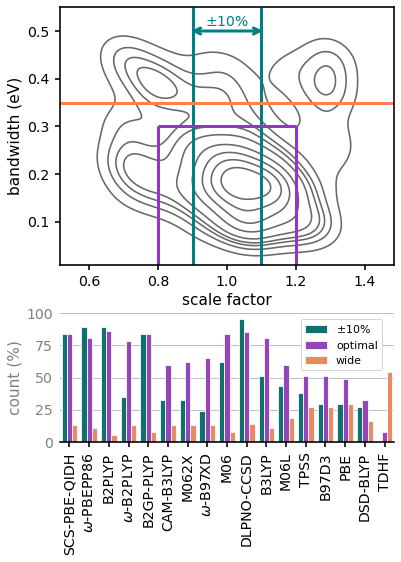

In [17]:
errors_mae = get_errors_db(fulldb, error_type='mae')
wide_errors_functionals = get_region(errors_mae, "wide", group_by="functional", percentages=True)
optimal_functionals = get_region(errors_mae, "optimal", group_by="functional", percentages=True)
tenpercent_functionals = get_region(errors_mae, "10%", group_by="functional", percentages=True)

wides_ = wide_errors_functionals.rename(columns={"percentage_count":"wide"}).drop(columns=["counts"])
optimals_ = optimal_functionals.rename(columns={"percentage_count":"optimal"}).drop(columns=["counts"])
tenpercents_ = tenpercent_functionals.rename(columns={"percentage_count":r'$\pm$10%'}).drop(columns=["counts"])
hits_grouped_ = tenpercents_.merge(optimals_, how="outer").merge(wides_, how="outer")
hits_grouped = pd.melt(hits_grouped_, id_vars="functional", value_vars=[r'$\pm$10%',"optimal","wide"], var_name="region", value_name="count_percentage")

scale=1.6
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

# Set up the grid
fig = plt.figure(figsize=(6,8))
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0.25)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# ax1 -- 2D histogram
sns.kdeplot(data=errors_mae, x="shift_factor", y="bandwidth",ax=ax1, color="dimgrey") # linestyles="--"
# sns.despine()
ax1.set_ylim(0.01,0.55)
ax1.set_xlim(0.514, 1.486)
ax1.vlines(x = 0.9, ymin = 0.01, ymax = 0.55,colors = c10,lw=3)
ax1.vlines(x = 1.1, ymin = 0.01, ymax = 0.55,colors = c10,lw=3)
ax1.vlines(x = 0.8, ymin = 0.01, ymax = 0.3,colors = cOpt,lw=3)
ax1.vlines(x = 1.2, ymin = 0.01, ymax = 0.3,colors = cOpt,lw=3)
ax1.hlines(y=0.3, xmin=0.8, xmax=1.2, color=cOpt, lw=3, )
ax1.hlines(y=0.35, xmin=0.514, xmax=1.486, color=cWide, lw=3)
ax1.annotate("",(0.89,0.5), (1.11,0.5), color=c10, arrowprops={'arrowstyle': '<->','lw':3,'facecolor':c10,'edgecolor':c10})
ax1.annotate(r'$\pm$10%',xy=(1.0,0.52),xytext=(0.935,0.51),color=c10,size=14)
ax1.set_xlabel('scale factor')
ax1.set_ylabel('bandwidth (eV)')

# ax2 -- bar plot
sns.barplot(ax=ax2,y="count_percentage", x="functional", data=hits_grouped, hue="region", palette=regionColors, order=mse_order, edgecolor="white")
ax2.legend(frameon=True, title=False, fontsize=11, facecolor="white", framealpha=1, loc='upper right', bbox_to_anchor=(0.98, 1.))
# loc='upper right', bbox_to_anchor=(0.98, 1.) --> put the legend's upper right-hand corner to the
#                                                  upper right (1.,1.) of the figure and shift along x by a little

ax2.set_ylim(0,100)
ax2.set_ylabel('count (%)', color = 'grey') # color = 'dimgrey'?
ax2.set_xlabel(None)
ax2.grid(axis = 'y')
ax2.set_axisbelow(True)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='y', which='major', pad=2., left=False, labelcolor='grey') # remove y tickmarkers and bring y ticklabels closer

for item in ax2.get_xticklabels():
    item.set_rotation(90)

# plt.tight_layout(pad=0.5)
plt.savefig('2D_hist_mae.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

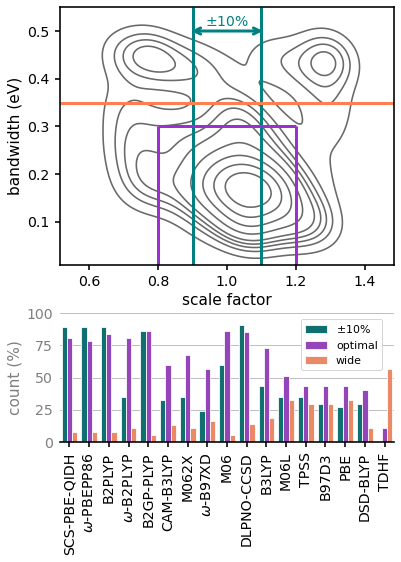

In [18]:
errors_rmsle = get_errors_db(fulldb, error_type='rmsle')
wide_errors_functionals = get_region(errors_rmsle, "wide", group_by="functional", percentages=True)
optimal_functionals = get_region(errors_rmsle, "optimal", group_by="functional", percentages=True)
tenpercent_functionals = get_region(errors_rmsle, "10%", group_by="functional", percentages=True)

wides_ = wide_errors_functionals.rename(columns={"percentage_count":"wide"}).drop(columns=["counts"])
optimals_ = optimal_functionals.rename(columns={"percentage_count":"optimal"}).drop(columns=["counts"])
tenpercents_ = tenpercent_functionals.rename(columns={"percentage_count":r'$\pm$10%'}).drop(columns=["counts"])
hits_grouped_ = tenpercents_.merge(optimals_, how="outer").merge(wides_, how="outer")
hits_grouped = pd.melt(hits_grouped_, id_vars="functional", value_vars=[r'$\pm$10%',"optimal","wide"], var_name="region", value_name="count_percentage")

scale=1.6
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

# Set up the grid
fig = plt.figure(figsize=(6,8))
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0.25)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# ax1 -- 2D histogram
sns.kdeplot(data=errors_rmsle, x="shift_factor", y="bandwidth",ax=ax1, color="dimgrey") # linestyles="--"
# sns.despine()
ax1.set_ylim(0.01,0.55)
ax1.set_xlim(0.514, 1.486)
ax1.vlines(x = 0.9, ymin = 0.01, ymax = 0.55,colors = c10,lw=3)
ax1.vlines(x = 1.1, ymin = 0.01, ymax = 0.55,colors = c10,lw=3)
ax1.vlines(x = 0.8, ymin = 0.01, ymax = 0.3,colors = cOpt,lw=3)
ax1.vlines(x = 1.2, ymin = 0.01, ymax = 0.3,colors = cOpt,lw=3)
ax1.hlines(y=0.3, xmin=0.8, xmax=1.2, color=cOpt, lw=3, )
ax1.hlines(y=0.35, xmin=0.514, xmax=1.486, color=cWide, lw=3)
ax1.annotate("",(0.89,0.5), (1.11,0.5), color=c10, arrowprops={'arrowstyle': '<->','lw':3,'facecolor':c10,'edgecolor':c10})
ax1.annotate(r'$\pm$10%',xy=(1.0,0.52),xytext=(0.935,0.51),color=c10,size=14)
ax1.set_xlabel('scale factor')
ax1.set_ylabel('bandwidth (eV)')

# ax2 -- bar plot
sns.barplot(ax=ax2,y="count_percentage", x="functional", data=hits_grouped, hue="region", palette=regionColors, order=mse_order, edgecolor="white")
ax2.legend(frameon=True, title=False, fontsize=11, facecolor="white", framealpha=1, loc='upper right', bbox_to_anchor=(0.98, 1.))
# loc='upper right', bbox_to_anchor=(0.98, 1.) --> put the legend's upper right-hand corner to the
#                                                  upper right (1.,1.) of the figure and shift along x by a little

ax2.set_ylim(0,100)
ax2.set_ylabel('count (%)', color = 'grey') # color = 'dimgrey'?
ax2.set_xlabel(None)
ax2.grid(axis = 'y')
ax2.set_axisbelow(True)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='y', which='major', pad=2., left=False, labelcolor='grey') # remove y tickmarkers and bring y ticklabels closer

for item in ax2.get_xticklabels():
    item.set_rotation(90)

# plt.tight_layout(pad=0.5)
plt.savefig('2D_hist_rmsle.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

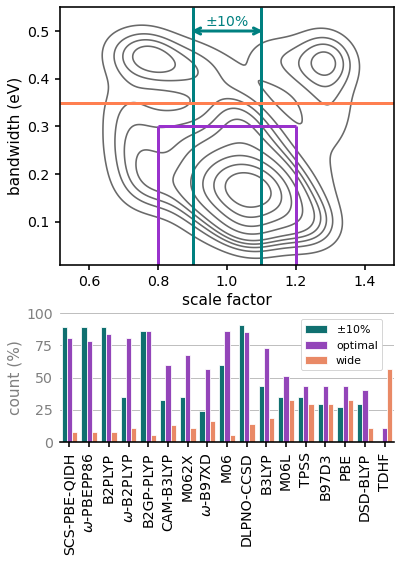

In [19]:
errors_R2 = get_errors_db(fulldb, error_type='R2')
wide_errors_functionals = get_region(errors_R2, "wide", group_by="functional", percentages=True)
optimal_functionals = get_region(errors_R2, "optimal", group_by="functional", percentages=True)
tenpercent_functionals = get_region(errors_R2, "10%", group_by="functional", percentages=True)

wides_ = wide_errors_functionals.rename(columns={"percentage_count":"wide"}).drop(columns=["counts"])
optimals_ = optimal_functionals.rename(columns={"percentage_count":"optimal"}).drop(columns=["counts"])
tenpercents_ = tenpercent_functionals.rename(columns={"percentage_count":r'$\pm$10%'}).drop(columns=["counts"])
hits_grouped_ = tenpercents_.merge(optimals_, how="outer").merge(wides_, how="outer")
hits_grouped = pd.melt(hits_grouped_, id_vars="functional", value_vars=[r'$\pm$10%',"optimal","wide"], var_name="region", value_name="count_percentage")

scale=1.6
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

# Set up the grid
fig = plt.figure(figsize=(6,8))
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0.25)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# ax1 -- 2D histogram
sns.kdeplot(data=errors_R2, x="shift_factor", y="bandwidth",ax=ax1, color="dimgrey") # linestyles="--"
# sns.despine()
ax1.set_ylim(0.01,0.55)
ax1.set_xlim(0.514, 1.486)
ax1.vlines(x = 0.9, ymin = 0.01, ymax = 0.55,colors = c10,lw=3)
ax1.vlines(x = 1.1, ymin = 0.01, ymax = 0.55,colors = c10,lw=3)
ax1.vlines(x = 0.8, ymin = 0.01, ymax = 0.3,colors = cOpt,lw=3)
ax1.vlines(x = 1.2, ymin = 0.01, ymax = 0.3,colors = cOpt,lw=3)
ax1.hlines(y=0.3, xmin=0.8, xmax=1.2, color=cOpt, lw=3, )
ax1.hlines(y=0.35, xmin=0.514, xmax=1.486, color=cWide, lw=3)
ax1.annotate("",(0.89,0.5), (1.11,0.5), color=c10, arrowprops={'arrowstyle': '<->','lw':3,'facecolor':c10,'edgecolor':c10})
ax1.annotate(r'$\pm$10%',xy=(1.0,0.52),xytext=(0.935,0.51),color=c10,size=14)
ax1.set_xlabel('scale factor')
ax1.set_ylabel('bandwidth (eV)')

# ax2 -- bar plot
sns.barplot(ax=ax2,y="count_percentage", x="functional", data=hits_grouped, hue="region", palette=regionColors, order=mse_order, edgecolor="white")
ax2.legend(frameon=True, title=False, fontsize=11, facecolor="white", framealpha=1, loc='upper right', bbox_to_anchor=(0.98, 1.))
# loc='upper right', bbox_to_anchor=(0.98, 1.) --> put the legend's upper right-hand corner to the
#                                                  upper right (1.,1.) of the figure and shift along x by a little

ax2.set_ylim(0,100)
ax2.set_ylabel('count (%)', color = 'grey') # color = 'dimgrey'?
ax2.set_xlabel(None)
ax2.grid(axis = 'y')
ax2.set_axisbelow(True)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='y', which='major', pad=2., left=False, labelcolor='grey') # remove y tickmarkers and bring y ticklabels closer

for item in ax2.get_xticklabels():
    item.set_rotation(90)

# plt.tight_layout(pad=0.5)
plt.savefig('2D_hist_R2.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

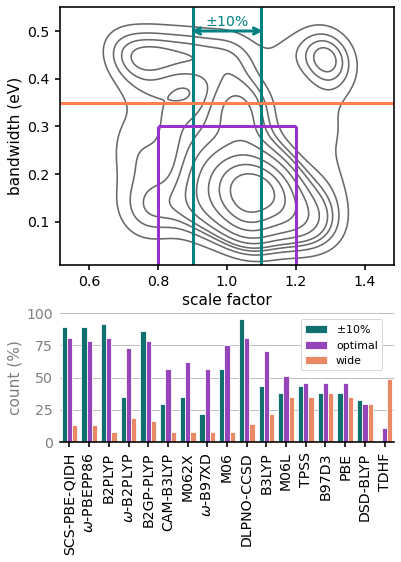

In [20]:
errors_pearson = get_errors_db(fulldb, error_type='r_square')
wide_errors_functionals = get_region(errors_pearson, "wide", group_by="functional", percentages=True)
optimal_functionals = get_region(errors_pearson, "optimal", group_by="functional", percentages=True)
tenpercent_functionals = get_region(errors_pearson, "10%", group_by="functional", percentages=True)

wides_ = wide_errors_functionals.rename(columns={"percentage_count":"wide"}).drop(columns=["counts"])
optimals_ = optimal_functionals.rename(columns={"percentage_count":"optimal"}).drop(columns=["counts"])
tenpercents_ = tenpercent_functionals.rename(columns={"percentage_count":r'$\pm$10%'}).drop(columns=["counts"])
hits_grouped_ = tenpercents_.merge(optimals_, how="outer").merge(wides_, how="outer")
hits_grouped = pd.melt(hits_grouped_, id_vars="functional", value_vars=[r'$\pm$10%',"optimal","wide"], var_name="region", value_name="count_percentage")

scale=1.6
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

# Set up the grid
fig = plt.figure(figsize=(6,8))
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0.25)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# ax1 -- 2D histogram
sns.kdeplot(data=errors_pearson, x="shift_factor", y="bandwidth",ax=ax1, color="dimgrey") # linestyles="--"
# sns.despine()
ax1.set_ylim(0.01,0.55)
ax1.set_xlim(0.514, 1.486)
ax1.vlines(x = 0.9, ymin = 0.01, ymax = 0.55,colors = c10,lw=3)
ax1.vlines(x = 1.1, ymin = 0.01, ymax = 0.55,colors = c10,lw=3)
ax1.vlines(x = 0.8, ymin = 0.01, ymax = 0.3,colors = cOpt,lw=3)
ax1.vlines(x = 1.2, ymin = 0.01, ymax = 0.3,colors = cOpt,lw=3)
ax1.hlines(y=0.3, xmin=0.8, xmax=1.2, color=cOpt, lw=3, )
ax1.hlines(y=0.35, xmin=0.514, xmax=1.486, color=cWide, lw=3)
ax1.annotate("",(0.89,0.5), (1.11,0.5), color=c10, arrowprops={'arrowstyle': '<->','lw':3,'facecolor':c10,'edgecolor':c10})
ax1.annotate(r'$\pm$10%',xy=(1.0,0.52),xytext=(0.935,0.51),color=c10,size=14)
ax1.set_xlabel('scale factor')
ax1.set_ylabel('bandwidth (eV)')

# ax2 -- bar plot
sns.barplot(ax=ax2,y="count_percentage", x="functional", data=hits_grouped, hue="region", palette=regionColors, order=mse_order, edgecolor="white")
ax2.legend(frameon=True, title=False, fontsize=11, facecolor="white", framealpha=1, loc='upper right', bbox_to_anchor=(0.98, 1.))
# loc='upper right', bbox_to_anchor=(0.98, 1.) --> put the legend's upper right-hand corner to the
#                                                  upper right (1.,1.) of the figure and shift along x by a little

ax2.set_ylim(0,100)
ax2.set_ylabel('count (%)', color = 'grey') # color = 'dimgrey'?
ax2.set_xlabel(None)
ax2.grid(axis = 'y')
ax2.set_axisbelow(True)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='y', which='major', pad=2., left=False, labelcolor='grey') # remove y tickmarkers and bring y ticklabels closer

for item in ax2.get_xticklabels():
    item.set_rotation(90)

# plt.tight_layout(pad=0.5)
plt.savefig('2D_hist_pearson.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

In [21]:
ttt = pred[pred['functional']=='DLPNO-CCSD'].molecule.unique()
tt = pred[pred['functional']=='M06'].molecule.unique()
np.setdiff1d(tt,ttt) # molecules not calculated with CCSD

array(['BOH-Acr_m', 'CA_1', 'CA_2', 'CA_3', 'Eos_2', 'Eos_3', 'Me2-Acr_2',
       'Mes-Acr_1', 'NCE_4', 'PDI_3', 'POZ_1', 'POZ_4', 'PTZ_1', 'PTZ_3',
       'Rh_6G', 'Rh_B'], dtype=object)

Plot the over- and underestimation tendency for each functional based on the value of the optimized scale factor parameter. The 10% region is considered "perfect" and occurrences of functionals above and below (in terms of scale factor) this region are collected.

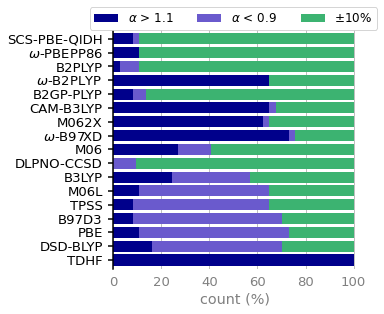

In [22]:
above_10_percent = get_region(errors, "above_10%").drop(columns=["counts"]).rename(columns={"percentage_count":r'$\alpha$ > 1.1'})
below_10_percent = get_region(errors, "below_10%").drop(columns=["counts"]).rename(columns={"percentage_count":r'$\alpha$ < 0.9'})
# alphaText = r'0.9 $\leq$ $\alpha$ $\leq$ 1.1'
alphaText = r'$\pm$10%'
in10percent = get_region(errors, "10%").drop(columns=["counts"]).rename(columns={"percentage_count":alphaText})
belabow_10_ = above_10_percent.merge(below_10_percent, how="outer").merge(in10percent, how="outer")

sns.reset_orig()
plt.style.use("seaborn-paper")

scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

palette = ['darkblue','slateblue','mediumseagreen'] # 'mediumseagreen' for more pop

ax = belabow_10_.set_index("functional").loc[reversed(mse_order)].plot(kind="barh",
                                                                         stacked=True, 
                                                                         y=[r'$\alpha$ > 1.1',r'$\alpha$ < 0.9',alphaText], 
                                                                         width=0.8, 
                                                                         color=palette)
ax.set_aspect(5.75) # aspect ratio of the axes scaling, i.e. y/x-scale
ax.set_axisbelow(True)

ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='major', pad=2., bottom=False, labelcolor='grey') # bring x ticklabels closer

# plt.legend([r'$\alpha$ > 1.1',r'$\alpha$ < 0.9',alphaText], 
#            frameon=True, title=None, fontsize=12, facecolor="white", framealpha=1, 
#            loc='upper right', bbox_to_anchor=(1., 1.))

plt.legend([r'$\alpha$ > 1.1',r'$\alpha$ < 0.9',alphaText], 
           frameon=True, title=None, fontsize=12, facecolor="white", framealpha=1, 
           loc='upper center', bbox_to_anchor=(0.495, 1.12), ncol=3)
plt.ylabel(None)
plt.xlabel('count (%)', color='grey')
plt.xlim(0,101)
plt.grid(axis = 'x')
# sns.despine()
plt.savefig('over_under_alpha.png', dpi=200, bbox_inches='tight', pad_inches=0.01)
plt.show()
plt.close()

## Distributions for functional types

Classify the molecules and functionals into categories for further analysis. 

> Note: from here on we define `molecule_types` and `functional_types` and insert these columns into the database

In [23]:
# fulldb = get_fulldb(db_loc) # reinitialize the full database

# insert molecule_types
molecule_types = {'PTZ_1': 'phenothiazine', 'CA_2': 'cyanoarene', 'NCE_3': 'naphthochromenone', 'Ph-Acr_2': 'phenylacridinium', 'POZ_5': 'phenoxazine', 'BOH-Acr_m': 'phenylacridinium',
                  'PDI_1': 'perylene diimide', 'PA_1': 'phenazine', 'PA_2': 'phenazine', 'Me2-Acr_1': 'dimethyl dihydroacridine', 'PDI_3': 'perylene diimide', 'CA_3': 'cyanoarene', 'NCE_2': 'naphthochromenone', 'PDI_2': 'perylene diimide',
                  'NCE_1': 'naphthochromenone', 'Me2-Acr_2': 'dimethyl dihydroacridine', 'BF3-Acr_p': 'phenylacridinium', 'Eos_3': 'xanthene', 'Eos_Y': 'xanthene', 'CA_1': 'cyanoarene',
                  'Eos_1': 'xanthene', 'Me2-Acr_3': 'dimethyl dihydroacridine', 'Eos_2': 'xanthene', 'POZ_4': 'phenoxazine', 'POZ_2': 'phenoxazine', 'POZ_3': 'phenoxazine', 'BF3-Acr_m': 'phenylacridinium',
                  'BF3-Acr_o': 'phenylacridinium', 'Rh_B': 'xanthene', 'BOH-Acr_o': 'phenylacridinium', 'PA_3': 'phenazine', 'Mes-Acr_1': 'phenylacridinium', 'NCE_4': 'naphthochromenone',
                  'PTZ_3': 'phenothiazine', 'Ph-Acr_1': 'phenylacridinium', 'PTZ_2': 'phenothiazine', 'BOH-Acr_p': 'phenylacridinium', 'Rh_6G': 'xanthene', 'POZ_1': 'phenoxazine'}
fulldb["molecule_type"] = fulldb["molecule"]
fulldb.replace({"molecule_type": molecule_types}, inplace=True)
cols = fulldb.columns.tolist()
fulldb = fulldb[['reference','molecule','molecule_type','functional','error_function',
                 'error_value','bandwidth','shift_factor','Wavelength [nm]','Intensity [a.u.]']]

# insert functional_types
functional_types = {'TDHF':'Hartree-Fock', '$\\omega$-B2PLYP':'double-hybrid', 'M06':'global-hybrid', 'B2PLYP':'double-hybrid', 
                    'CAM-B3LYP-D3':'rs-hybrid','M062X':'global-hybrid', 'TPSS':'pure-functional', 'DSD-BLYP':'double-hybrid', 
                    'B3LYP-D3':'global-hybrid', 'M06L':'pure-functional', 'PBE-D3':'pure-functional', 'B97D3':'pure-functional',
                    '$\\omega$-B97XD':'rs-hybrid', 'DLPNO-CCSD':'coupled-cluster', 'SCS-PBE-QIDH':'double-hybrid',
                    '$\\omega$-PBEPP86':'double-hybrid', 'B2GP-PLYP':'double-hybrid'}
fulldb["functional_type"] = fulldb["functional"]
fulldb.replace({"functional_type": functional_types}, inplace=True)
cols = fulldb.columns.tolist()
fulldb = fulldb[['reference','molecule','molecule_type','functional','functional_type','error_function',
                 'error_value','bandwidth','shift_factor','Wavelength [nm]','Intensity [a.u.]']]

# get the working error database
errors = get_errors_db(fulldb, error_type='mse')

# set plot defaults
scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

### 3 regions over functional types

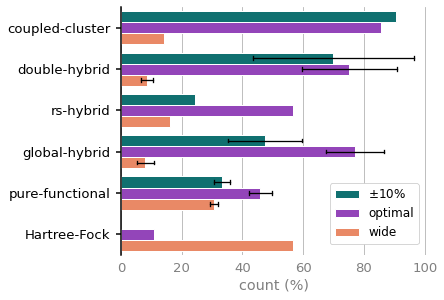

In [24]:
sns.reset_orig()
plt.style.use("seaborn-paper")

scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

wide_errors_ftypes = get_region(errors, "wide", group_by="functional")
optimal_ftypes = get_region(errors, "optimal", group_by="functional")
tenpercent_ftypes = get_region(errors, "10%", group_by="functional")

wides_ = wide_errors_ftypes.rename(columns={"percentage_count":"wide"}).drop(columns=["counts"])
optimals_ = optimal_ftypes.rename(columns={"percentage_count":"optimal"}).drop(columns=["counts"])
tenpercents_ = tenpercent_ftypes.rename(columns={"percentage_count":r'$\pm$10%'}).drop(columns=["counts"])

hits_grouped_ = tenpercents_.merge(optimals_, how="outer").merge(wides_, how="outer")
hits_grouped = pd.melt(hits_grouped_, id_vars="functional", value_vars=[r'$\pm$10%',"optimal","wide"], var_name="region", value_name="count_percentage")
hits_grouped["functional_type"] = hits_grouped["functional"]
hits_grouped.replace({"functional_type": functional_types}, inplace=True)

order = ['coupled-cluster','double-hybrid','rs-hybrid','global-hybrid','pure-functional','Hartree-Fock']

# ax = sns.barplot(x = "count_percentage", y = "functional_type", hue = "region", data = hits_grouped, 
#                  order=order, palette=regionColors, edgecolor="white", linewidth=1, 
#                  estimator=np.mean, ci=95, n_boot=1000, capsize=.1, errwidth=1.4) # bootstrapping, but for sample sizes this small it gets shifted from the center

ax = sns.barplot(x = "count_percentage", y = "functional_type", hue = "region", data = hits_grouped, 
                 order=order, palette=regionColors, edgecolor="white", linewidth=1, 
                 estimator=np.mean, ci="sd", capsize=.085, errwidth=1.3, errcolor='k') # standard deviation, although we cannot assume a normal distribution it looks better

ax.legend(frameon=True, title=False, fontsize=12, facecolor="white", framealpha=1, loc='lower right', bbox_to_anchor=(0.99, 0.02))
ax.grid(axis = 'x')
ax.set_axisbelow(True)

ax.spines['bottom'].set_visible(False) # also: {'xtick.major.width': 0} in sns.set_context()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='major', pad=2., bottom=False, labelcolor='grey') # bring x ticklabels closer

plt.ylabel(None)
plt.xlabel('count (%)', color='grey')
plt.xlim(0,101)
# sns.despine()
plt.tight_layout()
plt.savefig('func_types_grouped_withbars.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

## 3 regions over molecule frames

In [25]:
func_type_order = {0:'Hartree-Fock',1:'pure-functional',2:'global-hybrid',3:'rs-hybrid',4:'double-hybrid',5:'coupled-cluster'}
errors = get_errors_db(fulldb, error_type='mse')

Set up some additional variables (not used in this notebook version)

In [26]:
# func_type_list = fulldb.functional_type.unique().tolist()
# func_type_list.remove('expt.') # ['rs-hybrid', 'global-hybrid', 'double-hybrid', 'Hartree-Fock', 'pure-functional', 'coupled-cluster']
# moltypes = fulldb.molecule_type.unique().tolist()

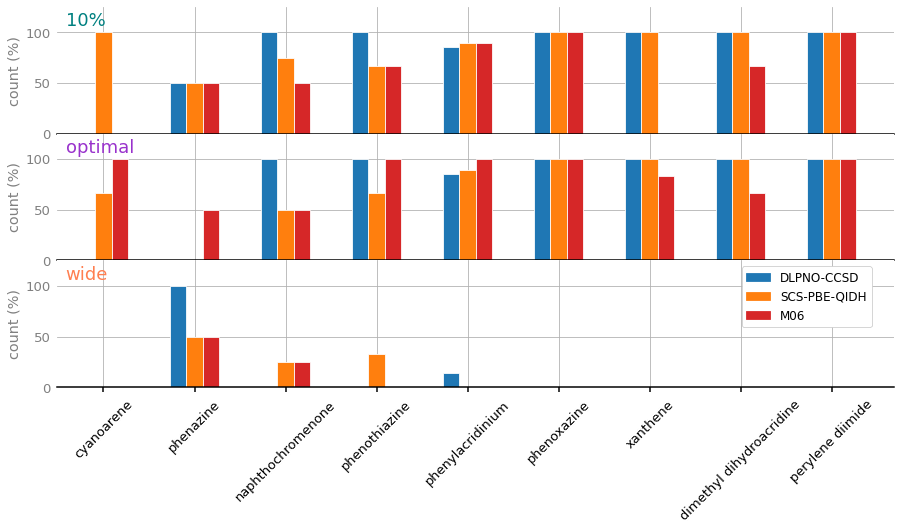

In [27]:
# functional_best= ['DLPNO-CCSD','B2PLYP','M06']
functional_best= ['DLPNO-CCSD','SCS-PBE-QIDH','M06']
errors3 = errors.loc[errors['functional'].isin(functional_best)]
# funcOrder = ['DLPNO-CCSD','B2PLYP','M06']
moltypes = ['cyanoarene','phenazine','naphthochromenone','phenothiazine','phenylacridinium',
            'phenoxazine','xanthene','dimethyl dihydroacridine', 'perylene diimide'] # need to specify explicitly to influence the ordering in the plots
palette_ = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            (1.0,0.4980392156862745, 0.054901960784313725),
            (0.8392156862745098, 0.15294117647058825,0.1568627450980392)]

db_ = pd.DataFrame()
for i, moltype in enumerate(moltypes):
    errors1 = errors3[errors3['molecule_type'] == moltype]
    wides = get_region(errors1, "wide",group_by="functional").drop(columns=["counts"]).rename(columns={"percentage_count":"wide"})
    optimals = get_region(errors1, "opt",group_by="functional").drop(columns=["counts"]).rename(columns={"percentage_count":"optimal"})
    tenpercent = get_region(errors1, "10%",group_by="functional").drop(columns=["counts"]).rename(columns={"percentage_count":"10%"})

    merged_db_ = tenpercent.merge(optimals, how="outer").merge(wides, how="outer")
    merged_db = pd.melt(merged_db_, id_vars=["functional"],value_vars=["10%","optimal","wide"], var_name="region", value_name="count%")
    merged_db["moltype"] = moltype
    db_ = db_.append(merged_db)

regions = ["10%","optimal","wide"]
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(15,7),sharey=True,sharex=True,frameon=False)
plt.subplots_adjust(hspace=0)
x = np.arange(len(moltypes))
width=0.18
numfunctype=len(functional_best)
koz=-0.0
start=-numfunctype/2*width+width/2
for moltype in moltypes:
    ind_m = moltypes.index(moltype)
    for ftype in functional_best:
        ind_f = functional_best.index(ftype)
        for i, ax in enumerate(axes):
            db_aux  = db_[db_['region']==regions[i]]
            db_aux2 = db_aux[db_aux['functional']==ftype]
            ax.bar(x[ind_m]+start+ind_f*(width-koz),db_aux2[db_aux2['moltype']==moltype]['count%'],
                   width,color=palette_[ind_f],label=ftype,edgecolor='white')

for i, ax in enumerate(axes):
    if i < 2: # first two axes
        ax.set_xticklabels('')
    ax.text(0.01,.85,regions[i],horizontalalignment='left',
            transform=ax.transAxes,fontsize=18, color=regionColors[i])
    ax.set_ylim(0,125)
    ax.set_xlabel(None)
    ax.set_ylabel('count (%)', color='grey')
    ax.grid(axis = 'both')
    ax.set_axisbelow(True)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', which='major', pad=2., left=False, labelcolor='grey')

axes[2].set_xticks([0,1,2,3,4,5,6,7,8])
# axes[2].set_xticklabels(moltypes, rotation=60, ha='right',fontsize=14)
axes[2].set_xticklabels(moltypes, fontsize=13)
# legend:
legendcolors = {functional_best[0]:palette_[0],functional_best[1]:palette_[1],functional_best[2]:palette_[2]}
labels = list(legendcolors.keys())
handles = [plt.Rectangle((0,0),1,1, color=legendcolors[label]) for label in labels]
axes[2].legend(handles, labels, loc='upper right', fontsize=12, 
               facecolor="white", framealpha=1, bbox_to_anchor=(0.98, 1.))
# plt.xticks(rotation=45,ha='right')
plt.xticks(rotation=45, ha='center')
plt.savefig('3_regions_moltypes_3best.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

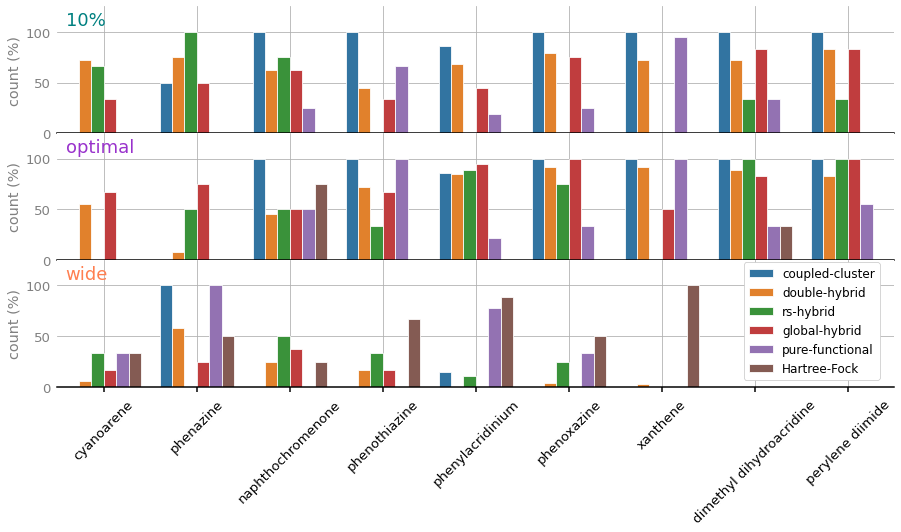

In [28]:
# errors = get_errors_db(fulldb, error_type='mse') # reinitialize database for safety

moltypeOrder = ['cyanoarene','phenazine','naphthochromenone',
                'phenothiazine','phenylacridinium','phenoxazine', 
                'xanthene','dimethyl dihydroacridine', 'perylene diimide']
hueOrder = ['coupled-cluster', 'double-hybrid', 'rs-hybrid', 'global-hybrid', 'pure-functional', 'Hartree-Fock']

db_ = pd.DataFrame()
for i, moltype in enumerate(moltypes):
  errors1 = errors[errors['molecule_type'] == moltype]
  wides = get_region(errors1, "wide", group_by="functional_type").drop(columns=["counts"]).rename(columns={"percentage_count":"wide"})
  optimals = get_region(errors1, "opt", group_by="functional_type").drop(columns=["counts"]).rename(columns={"percentage_count":"optimal"})
  tenpercent = get_region(errors1, "10%", group_by="functional_type").drop(columns=["counts"]).rename(columns={"percentage_count":"10%"})

  merged_db_ = tenpercent.merge(optimals, how="outer").merge(wides, how="outer")
  merged_db = pd.melt(merged_db_, id_vars=["functional_type"], value_vars=["10%","optimal","wide"], var_name="region", value_name="count%")
  merged_db["moltype"] = moltype
  db_ = db_.append(merged_db)

regions = ["10%","optimal","wide"]
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(15,7),sharey=True,sharex=False,frameon=False)
plt.subplots_adjust(hspace=0)
for i, ax in enumerate(axes):
  sns.barplot(ax=ax, data=db_.query(f"region == '{regions[i]}'"), x="moltype", y="count%", hue="functional_type", order=moltypeOrder, hue_order=hueOrder, edgecolor="white")
  # sns.barplot(ax=ax, data=db_.query(f"region == '{regions[i]}'"), x="moltype", y="count%", hue="functional", order=moltypeOrder, palette=palette_, edgecolor="white")
  if i < 2: # first two axes
    ax.set_xticklabels('')
    ax.get_legend().remove()
  else:
    ax.legend(frameon=True, title=False, fontsize=12, facecolor="white", framealpha=1, loc='upper right', bbox_to_anchor=(0.99, 1.03))
    # for item in ax.get_xticklabels():
    #   item.set_rotation(45)
  ax.text(0.01,.85,regions[i],horizontalalignment='left',transform=ax.transAxes, fontsize=18, color=regionColors[i])
  ax.set_ylim(0,125)
  ax.set_xlabel(None)
  ax.set_ylabel('count (%)', color='grey')
  ax.grid(axis = 'both')
  ax.set_axisbelow(True)
  ax.spines['left'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.tick_params(axis='y', which='major', pad=2., left=False, labelcolor='grey') # bring x ticklabels closer
  # sns.despine()

plt.xticks(rotation=45)
plt.savefig('3_regions_moltypes_funcgroups.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

## Spectra

Plot the fitted spectra (using the optimized bandwidth and scale parameters) together with the experimental reference spectra.

> Note: we divided the functionals into three groups for better visibility so there are three plots per molecule

In [29]:
pal={'TDHF':'#1f77b4','B97D3':'#ff7f0e','TPSS':'#2ca02c','M06L':'#d62728','PBE':'#9467bd','B3LYP':'#1f77b4',
     'CAM-B3LYP':'#ff7f0e','M06':'#2ca02c','M062X':'#d62728','$\\omega$-B97XD':'#9467bd','B2PLYP':'#1f77b4',
     'DSD-BLYP':'#ff7f0e','$\\omega$-B2PLYP':'#2ca02c','DLPNO-CCSD':'#d62728', 'SCS-PBE-QIDH':'#9467bd',
     '$\\omega$-PBEPP86':'darkviolet','B2GP-PLYP':'teal'}
func1=['TDHF', 'TPSS', 'PBE', 'M06L', 'B97D3']
func2=['M06','M062X', 'B3LYP','CAM-B3LYP', '$\\omega$-B97XD']
func3=['B2PLYP', '$\\omega$-B2PLYP', 'DSD-BLYP','DLPNO-CCSD','SCS-PBE-QIDH','$\\omega$-PBEPP86','B2GP-PLYP']

Spectra for the main text.

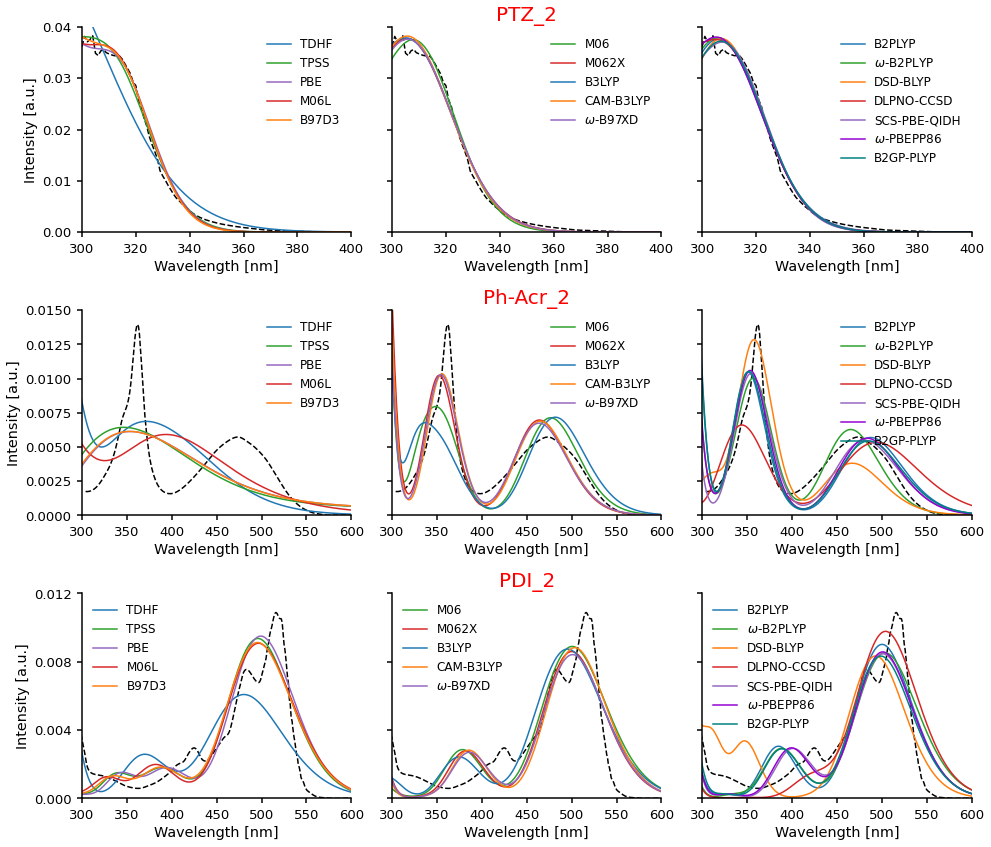

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,12), sharex="row", sharey="row")
#fig.subplots_adjust(hspace=0.3)

moleculesList = ["PTZ_2","Ph-Acr_2","PDI_2"]
# moleculesList = ["CA_1","CA_2","CA_3"]
for i, mol in enumerate(moleculesList):
  molecule = fulldb[fulldb['molecule'] == mol]
  expt = molecule[molecule['reference'] == 'yes']
  #pred = molecule[molecule['reference'] == 'no']
  mse_db = molecule[molecule['error_function'] == 'mse']
  mse_db1 = mse_db[mse_db['functional'].isin(func1)]
  mse_db2 = mse_db[mse_db['functional'].isin(func2)]
  mse_db3 = mse_db[mse_db['functional'].isin(func3)]

  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=func1).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=func2).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=func3).legend(frameon=False,fontsize='12',ncol=1)

  # title = f"-------------------------- {mol} -------------------------------"
  title = mol
  ax[i][1].set_title(title, color="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
  if mol == "PTZ_2":
    ax[i][0].set_xlim(300,400) # x and y is shared over rows so only need to set it once per row
    ax[i][0].set_ylim(0,0.04)
  elif mol == "Ph-Acr_2":
    ax[i][0].set_xlim(300,600)
    ax[i][0].set_ylim(0,0.015007)
  elif mol == "PDI_2":
    ax[i][0].set_xlim(300,600)
    ax[i][0].set_ylim(0,0.01201)
    start, end = ax[i][0].get_ylim()
    ax[i][0].yaxis.set_ticks(np.arange(start, end, 0.004))


plt.tight_layout()
sns.despine()
plt.savefig('3x3_spectra_different.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

Spectra for the rest of the molecules.

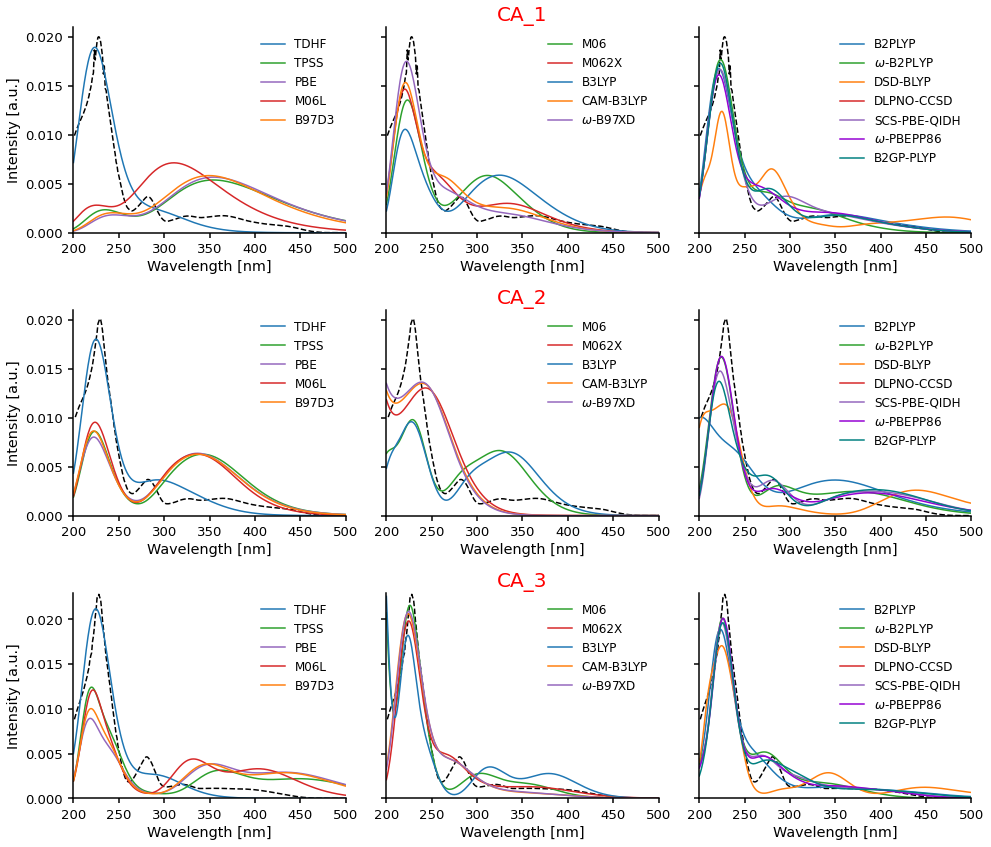

In [31]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,12), sharex="row", sharey="row")
#fig.subplots_adjust(hspace=0.3)

moleculesList = ["CA_1","CA_2","CA_3"]
for i, mol in enumerate(moleculesList):
  molecule = fulldb[fulldb['molecule'] == mol]
  expt = molecule[molecule['reference'] == 'yes']
  #pred = molecule[molecule['reference'] == 'no']
  mse_db = molecule[molecule['error_function'] == 'mse']
  mse_db1 = mse_db[mse_db['functional'].isin(func1)]
  mse_db2 = mse_db[mse_db['functional'].isin(func2)]
  mse_db3 = mse_db[mse_db['functional'].isin(func3)]

  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=func1).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=func2).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=func3).legend(frameon=False,fontsize='12',ncol=1)

  # title = f"-------------------------- {mol} -------------------------------"
  title = mol
  ax[i][1].set_title(title, c="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
  if mol == "CA_1":
    ax[i][0].set_xlim(200,500) # x and y is shared over rows so only need to set it once per row
    ax[i][0].set_ylim(0,0.021)
  elif mol == "CA_2":
    ax[i][0].set_xlim(200,500)
    ax[i][0].set_ylim(0,0.021)
  elif mol == "CA_3":
    ax[i][0].set_xlim(200,500)
    ax[i][0].set_ylim(0,0.023)
    # start, end = ax[i][0].get_ylim()
    # ax[i][0].yaxis.set_ticks(np.arange(start, end, 0.004))


plt.tight_layout()
sns.despine()
plt.savefig('CA_spectra.png', dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

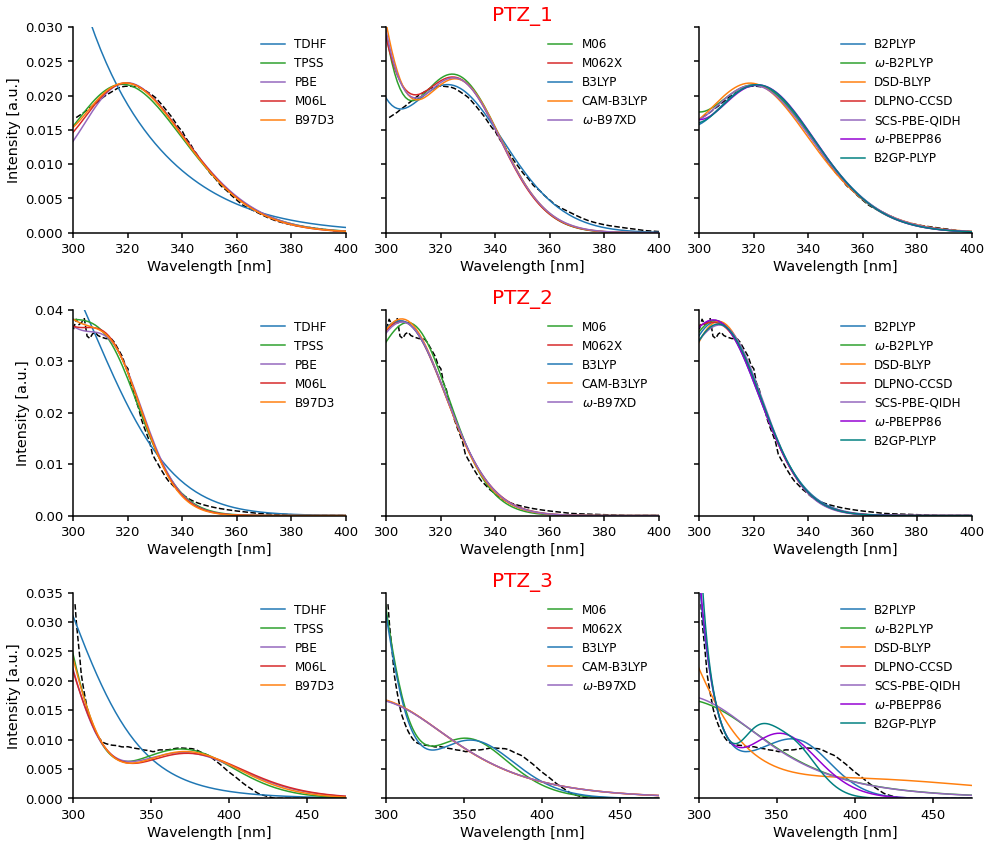

In [32]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,12), sharex="row", sharey="row")
#fig.subplots_adjust(hspace=0.3)

moleculesList = ['PTZ_1', 'PTZ_2', 'PTZ_3']
for i, mol in enumerate(moleculesList):
  molecule = fulldb[fulldb['molecule'] == mol]
  expt = molecule[molecule['reference'] == 'yes']
  #pred = molecule[molecule['reference'] == 'no']
  mse_db = molecule[molecule['error_function'] == 'mse']
  mse_db1 = mse_db[mse_db['functional'].isin(func1)]
  mse_db2 = mse_db[mse_db['functional'].isin(func2)]
  mse_db3 = mse_db[mse_db['functional'].isin(func3)]

  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=func1).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=func2).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=func3).legend(frameon=False,fontsize='12',ncol=1)

  # title = f"-------------------------- {mol} -------------------------------"
  title = mol
  ax[i][1].set_title(title, c="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
  if mol == "PTZ_2":
    ax[i][0].set_xlim(300,400) # x and y is shared over rows so only need to set it once per row
    ax[i][0].set_ylim(0,0.04)
  elif mol == "PTZ_1":
    ax[i][0].set_xlim(300,400)
    ax[i][0].set_ylim(0,0.03)
  elif mol == "PTZ_3":
    ax[i][0].set_xlim(300,475)
    ax[i][0].set_ylim(0,0.035)
    # start, end = ax[i][0].get_ylim()
    # ax[i][0].yaxis.set_ticks(np.arange(start, end, 0.004))


plt.tight_layout()
sns.despine()
plt.savefig('PTZ_spectra.png', dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

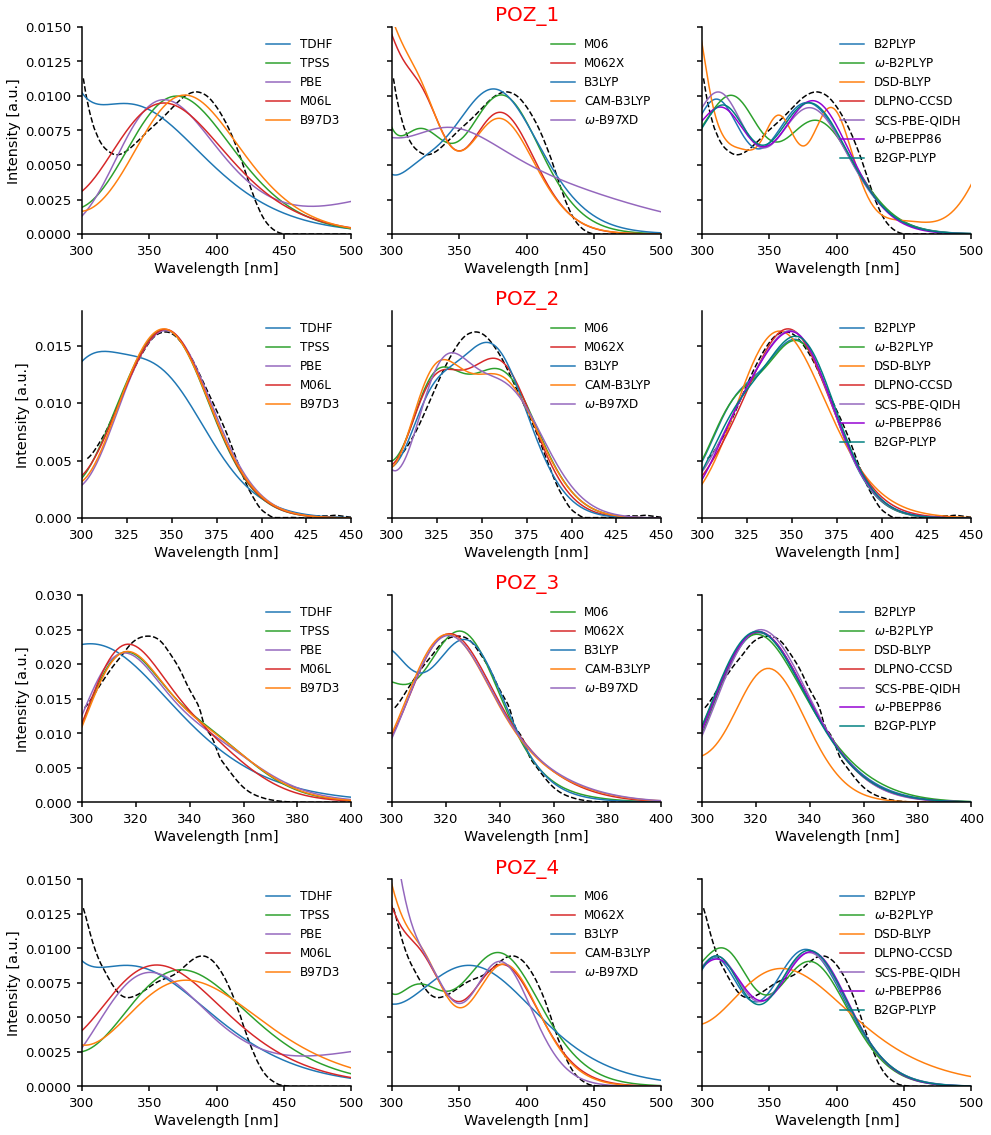

In [33]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,16), sharex="row", sharey="row")
#fig.subplots_adjust(hspace=0.3)

# moleculesList = ['POZ_1', 'POZ_3', 'POZ_4', 'POZ_5']
moleculesList = ['POZ_1', 'POZ_2', 'POZ_3', 'POZ_4']
for i, mol in enumerate(moleculesList):
  molecule = fulldb[fulldb['molecule'] == mol]
  expt = molecule[molecule['reference'] == 'yes']
  #pred = molecule[molecule['reference'] == 'no']
  mse_db = molecule[molecule['error_function'] == 'mse']
  mse_db1 = mse_db[mse_db['functional'].isin(func1)]
  mse_db2 = mse_db[mse_db['functional'].isin(func2)]
  mse_db3 = mse_db[mse_db['functional'].isin(func3)]

  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=func1).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=func2).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=func3).legend(frameon=False,fontsize='12',ncol=1)

  # title = f"-------------------------- {mol} -------------------------------"
  title = mol
  ax[i][1].set_title(title, c="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
  if mol == "POZ_1":
    ax[i][0].set_xlim(300,500) # x and y is shared over rows so only need to set it once per row
    ax[i][0].set_ylim(0,0.015)
  elif mol == "POZ_2":
    ax[i][0].set_xlim(300,450)
    ax[i][0].set_ylim(0,0.018)
  elif mol == "POZ_3":
    ax[i][0].set_xlim(300,400)
    ax[i][0].set_ylim(0,0.03)
    # start, end = ax[i][0].get_ylim()
    # ax[i][0].yaxis.set_ticks(np.arange(start, end, 0.004))
  elif mol == "POZ_4":
    ax[i][0].set_xlim(300,500)
    ax[i][0].set_ylim(0,0.015)


plt.tight_layout()
sns.despine()
plt.savefig('POZ_spectra.png', dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

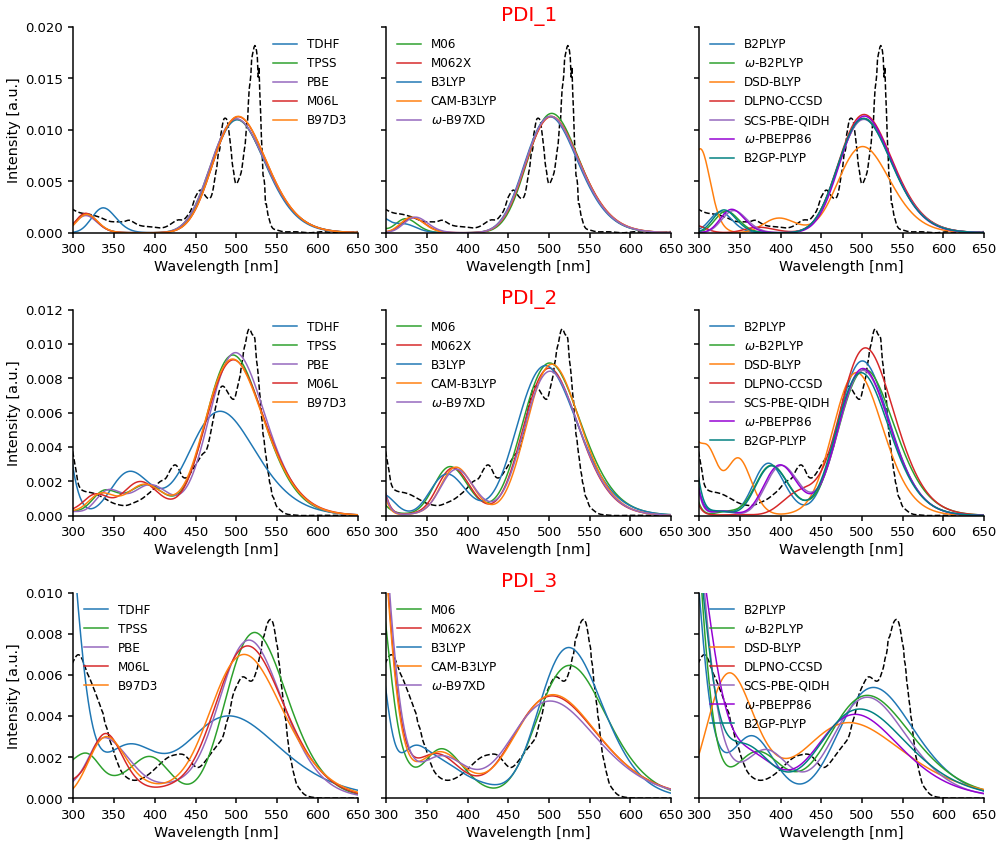

In [34]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,12), sharex="row", sharey="row")
#fig.subplots_adjust(hspace=0.3)

moleculesList = ['PDI_1', 'PDI_2', 'PDI_3']
for i, mol in enumerate(moleculesList):
  molecule = fulldb[fulldb['molecule'] == mol]
  expt = molecule[molecule['reference'] == 'yes']
  #pred = molecule[molecule['reference'] == 'no']
  mse_db = molecule[molecule['error_function'] == 'mse']
  mse_db1 = mse_db[mse_db['functional'].isin(func1)]
  mse_db2 = mse_db[mse_db['functional'].isin(func2)]
  mse_db3 = mse_db[mse_db['functional'].isin(func3)]

  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=func1).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=func2).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=func3).legend(frameon=False,fontsize='12',ncol=1)

  # title = f"-------------------------- {mol} -------------------------------"
  title = mol
  ax[i][1].set_title(title, c="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
  if mol == "PDI_1":
    ax[i][0].set_xlim(300,650) # x and y is shared over rows so only need to set it once per row
    ax[i][0].set_ylim(0,0.02)
  elif mol == "PDI_2":
    ax[i][0].set_xlim(300,650)
    ax[i][0].set_ylim(0,0.012)
  elif mol == "PDI_3":
    ax[i][0].set_xlim(300,650)
    ax[i][0].set_ylim(0,0.01)
    # start, end = ax[i][0].get_ylim()
    # ax[i][0].yaxis.set_ticks(np.arange(start, end, 0.004))


plt.tight_layout()
sns.despine()
plt.savefig('PDI_spectra.png', dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

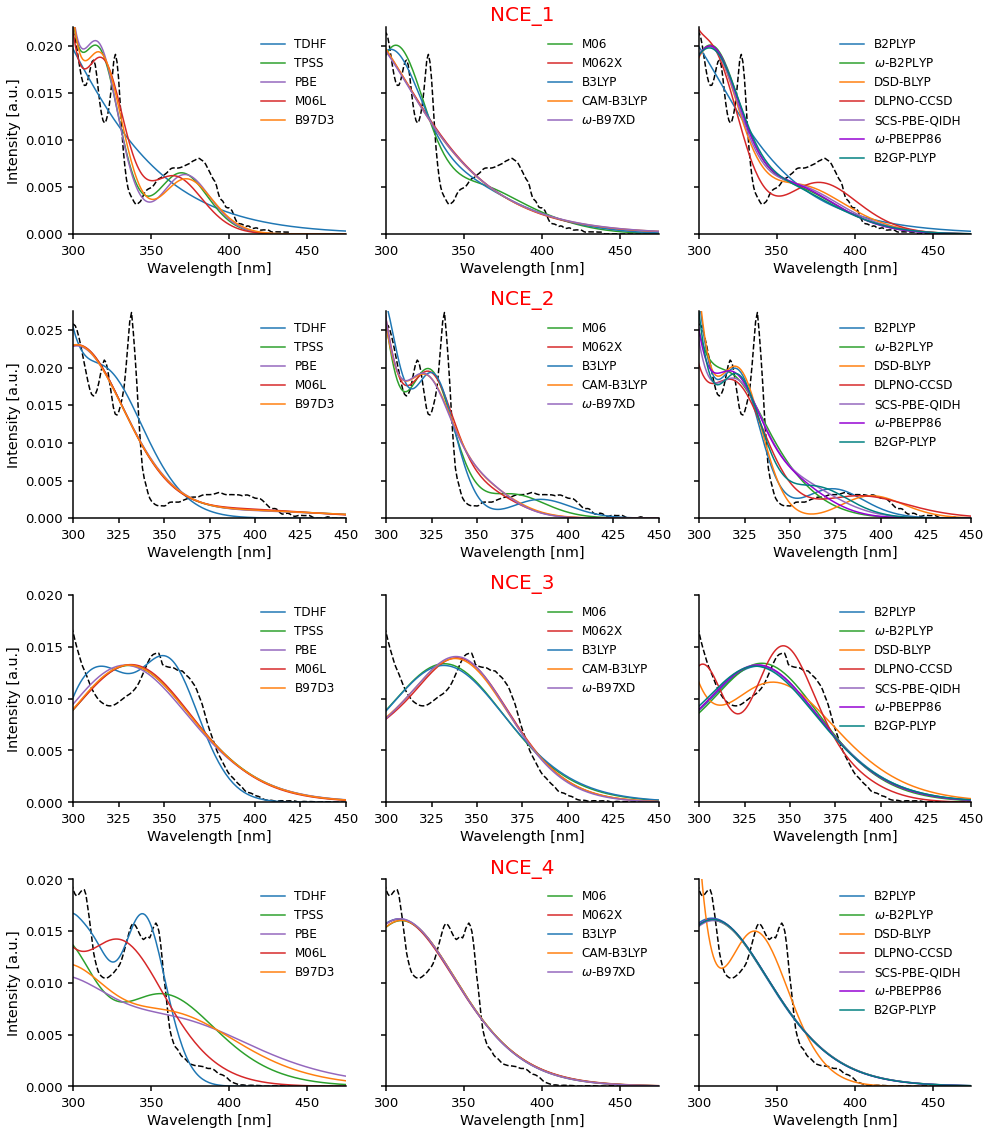

In [35]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,16), sharex="row", sharey="row")
#fig.subplots_adjust(hspace=0.3)

moleculesList = ['NCE_1', 'NCE_2', 'NCE_3', 'NCE_4']
for i, mol in enumerate(moleculesList):
  molecule = fulldb[fulldb['molecule'] == mol]
  expt = molecule[molecule['reference'] == 'yes']
  #pred = molecule[molecule['reference'] == 'no']
  mse_db = molecule[molecule['error_function'] == 'mse']
  mse_db1 = mse_db[mse_db['functional'].isin(func1)]
  mse_db2 = mse_db[mse_db['functional'].isin(func2)]
  mse_db3 = mse_db[mse_db['functional'].isin(func3)]

  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=func1).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=func2).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=func3).legend(frameon=False,fontsize='12',ncol=1)

  # title = f"-------------------------- {mol} -------------------------------"
  title = mol
  ax[i][1].set_title(title, c="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
  if mol == "NCE_1":
    ax[i][0].set_xlim(300,475) # x and y is shared over rows so only need to set it once per row
    ax[i][0].set_ylim(0,0.022)
  elif mol == "NCE_2":
    ax[i][0].set_xlim(300,450)
    ax[i][0].set_ylim(0,0.0275)
  elif mol == "NCE_3":
    ax[i][0].set_xlim(300,450)
    ax[i][0].set_ylim(0,0.02)
    # start, end = ax[i][0].get_ylim()
    # ax[i][0].yaxis.set_ticks(np.arange(start, end, 0.004))
  elif mol == "NCE_4":
    ax[i][0].set_xlim(300,475)
    ax[i][0].set_ylim(0,0.02)


plt.tight_layout()
sns.despine()
plt.savefig('NCE_spectra.png', dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

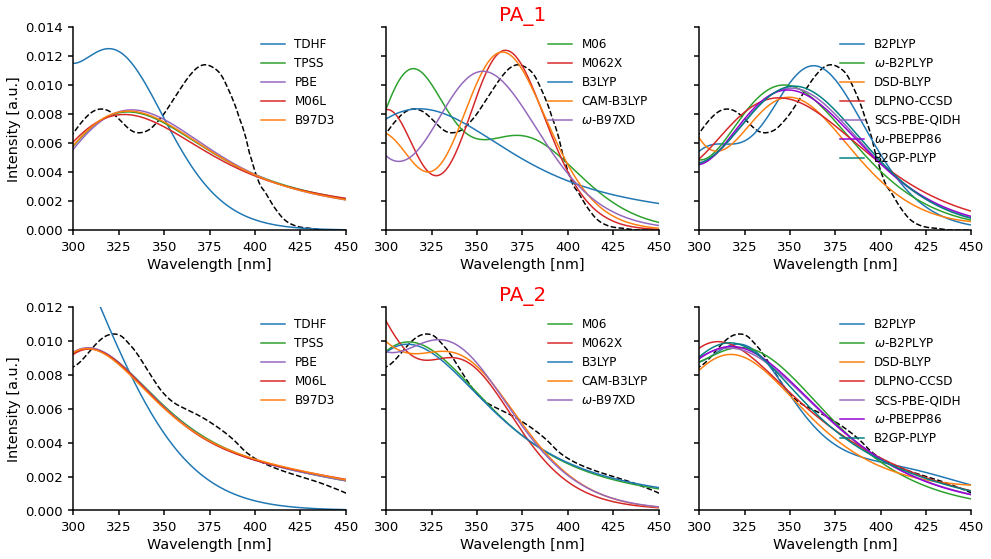

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,8), sharex="row", sharey="row")
#fig.subplots_adjust(hspace=0.3)

# moleculesList = ['PA_1', 'PA_3']
moleculesList = ['PA_1', 'PA_2']
for i, mol in enumerate(moleculesList):
  molecule = fulldb[fulldb['molecule'] == mol]
  expt = molecule[molecule['reference'] == 'yes']
  #pred = molecule[molecule['reference'] == 'no']
  mse_db = molecule[molecule['error_function'] == 'mse']
  mse_db1 = mse_db[mse_db['functional'].isin(func1)]
  mse_db2 = mse_db[mse_db['functional'].isin(func2)]
  mse_db3 = mse_db[mse_db['functional'].isin(func3)]

  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=func1).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=func2).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=func3).legend(frameon=False,fontsize='12',ncol=1)

  # title = f"-------------------------- {mol} -------------------------------"
  title = mol
  ax[i][1].set_title(title, c="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
  if mol == "PA_1":
    ax[i][0].set_xlim(300,450) # x and y is shared over rows so only need to set it once per row
    ax[i][0].set_ylim(0,0.014)
  elif mol == "PA_2":
    ax[i][0].set_xlim(300,450)
    ax[i][0].set_ylim(0,0.012)



plt.tight_layout()
sns.despine()
plt.savefig('PA_spectra.png', dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

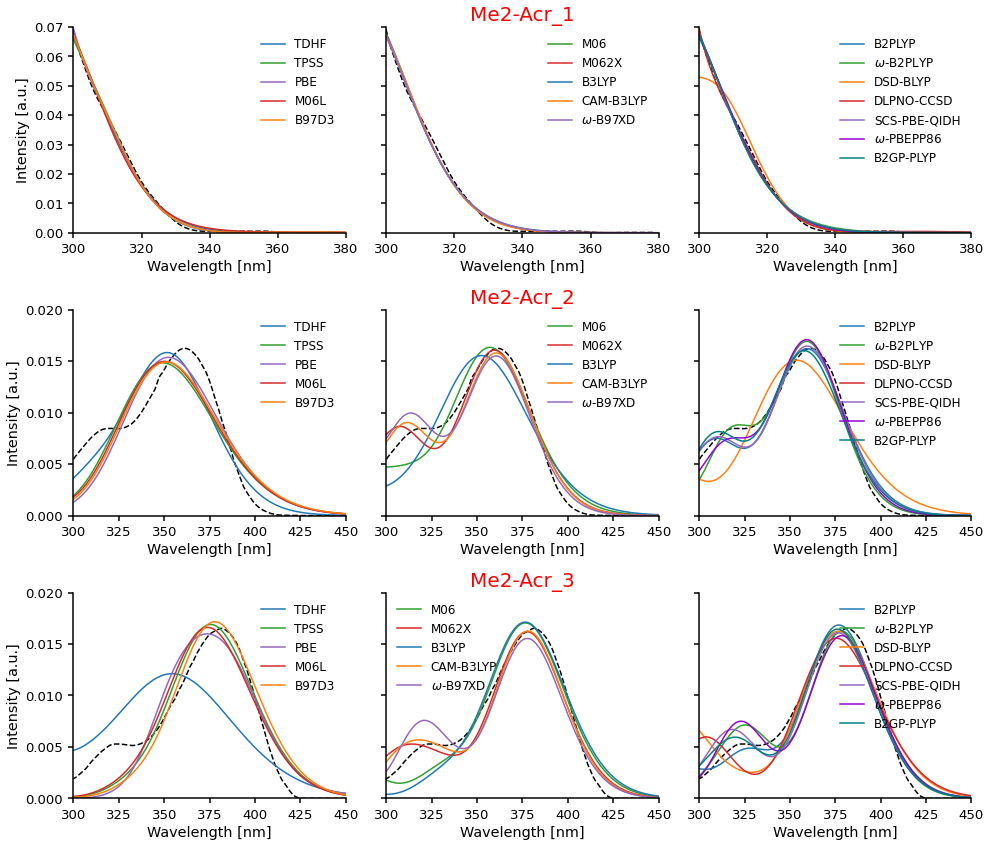

In [37]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,12), sharex="row", sharey="row")
#fig.subplots_adjust(hspace=0.3)

moleculesList = ['Me2-Acr_1', 'Me2-Acr_2', 'Me2-Acr_3']
for i, mol in enumerate(moleculesList):
  molecule = fulldb[fulldb['molecule'] == mol]
  expt = molecule[molecule['reference'] == 'yes']
  #pred = molecule[molecule['reference'] == 'no']
  mse_db = molecule[molecule['error_function'] == 'mse']
  mse_db1 = mse_db[mse_db['functional'].isin(func1)]
  mse_db2 = mse_db[mse_db['functional'].isin(func2)]
  mse_db3 = mse_db[mse_db['functional'].isin(func3)]

  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=func1).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=func2).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=func3).legend(frameon=False,fontsize='12',ncol=1)

  # title = f"-------------------------- {mol} -------------------------------"
  title = mol
  ax[i][1].set_title(title, c="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
  if mol == "Me2-Acr_1":
    ax[i][0].set_xlim(300,380) # x and y is shared over rows so only need to set it once per row
    ax[i][0].set_ylim(0,0.07)
  elif mol == "Me2-Acr_2":
    ax[i][0].set_xlim(300,450)
    ax[i][0].set_ylim(0,0.02)
  elif mol == "Me2-Acr_3":
    ax[i][0].set_xlim(300,450)
    ax[i][0].set_ylim(0,0.02)
    # start, end = ax[i][0].get_ylim()
    # ax[i][0].yaxis.set_ticks(np.arange(start, end, 0.004))


plt.tight_layout()
sns.despine()
plt.savefig('Me2-Acr_spectra.png', dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

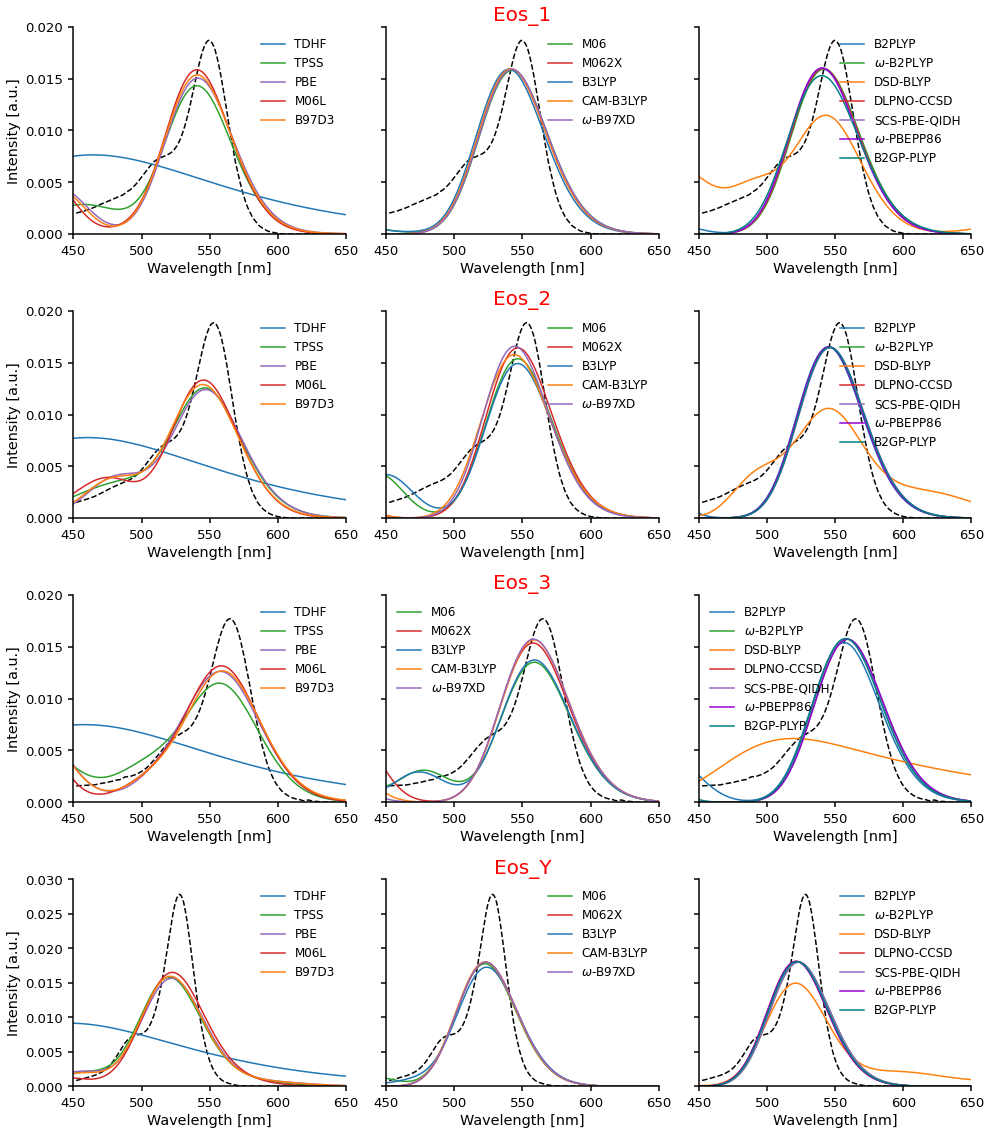

In [38]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,16), sharex="row", sharey="row")
#fig.subplots_adjust(hspace=0.3)

moleculesList = ['Eos_1', 'Eos_2', 'Eos_3', 'Eos_Y']
for i, mol in enumerate(moleculesList):
  molecule = fulldb[fulldb['molecule'] == mol]
  expt = molecule[molecule['reference'] == 'yes']
  #pred = molecule[molecule['reference'] == 'no']
  mse_db = molecule[molecule['error_function'] == 'mse']
  mse_db1 = mse_db[mse_db['functional'].isin(func1)]
  mse_db2 = mse_db[mse_db['functional'].isin(func2)]
  mse_db3 = mse_db[mse_db['functional'].isin(func3)]

  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=func1).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=func2).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=func3).legend(frameon=False,fontsize='12',ncol=1)

  # title = f"-------------------------- {mol} -------------------------------"
  title = mol
  ax[i][1].set_title(title, c="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
  if mol == "Eos_1":
    ax[i][0].set_xlim(450,650) # x and y is shared over rows so only need to set it once per row
    ax[i][0].set_ylim(0,0.02)
  elif mol == "Eos_2":
    ax[i][0].set_xlim(450,650)
    ax[i][0].set_ylim(0,0.02)
  elif mol == "Eos_3":
    ax[i][0].set_xlim(450,650)
    ax[i][0].set_ylim(0,0.02)
    # start, end = ax[i][0].get_ylim()
    # ax[i][0].yaxis.set_ticks(np.arange(start, end, 0.004))
  elif mol == "Eos_Y":
    ax[i][0].set_xlim(450,650)
    ax[i][0].set_ylim(0,0.03)


plt.tight_layout()
sns.despine()
plt.savefig('Eos_spectra.png', dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

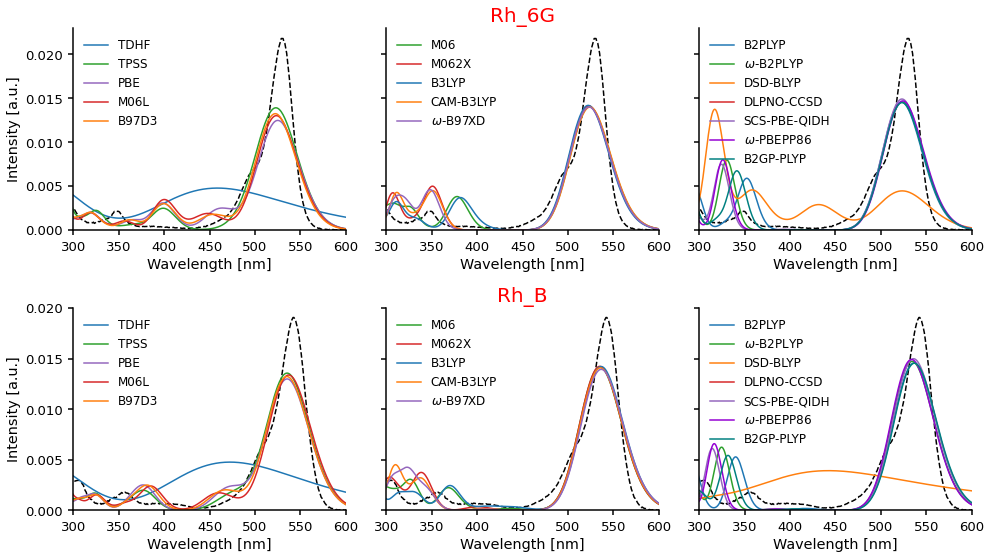

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,8), sharex="row", sharey="row")
#fig.subplots_adjust(hspace=0.3)

moleculesList = ['Rh_6G', 'Rh_B']
for i, mol in enumerate(moleculesList):
  molecule = fulldb[fulldb['molecule'] == mol]
  expt = molecule[molecule['reference'] == 'yes']
  #pred = molecule[molecule['reference'] == 'no']
  mse_db = molecule[molecule['error_function'] == 'mse']
  mse_db1 = mse_db[mse_db['functional'].isin(func1)]
  mse_db2 = mse_db[mse_db['functional'].isin(func2)]
  mse_db3 = mse_db[mse_db['functional'].isin(func3)]

  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=func1).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=func2).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=func3).legend(frameon=False,fontsize='12',ncol=1)

  # title = f"-------------------------- {mol} -------------------------------"
  title = mol
  ax[i][1].set_title(title, c="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
  if mol == "Rh_6G":
    ax[i][0].set_xlim(300,600) # x and y is shared over rows so only need to set it once per row
    ax[i][0].set_ylim(0,0.023)
  elif mol == "Rh_B":
    ax[i][0].set_xlim(300,600)
    ax[i][0].set_ylim(0,0.02)


plt.tight_layout()
sns.despine()
plt.savefig('Rh_spectra.png', dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

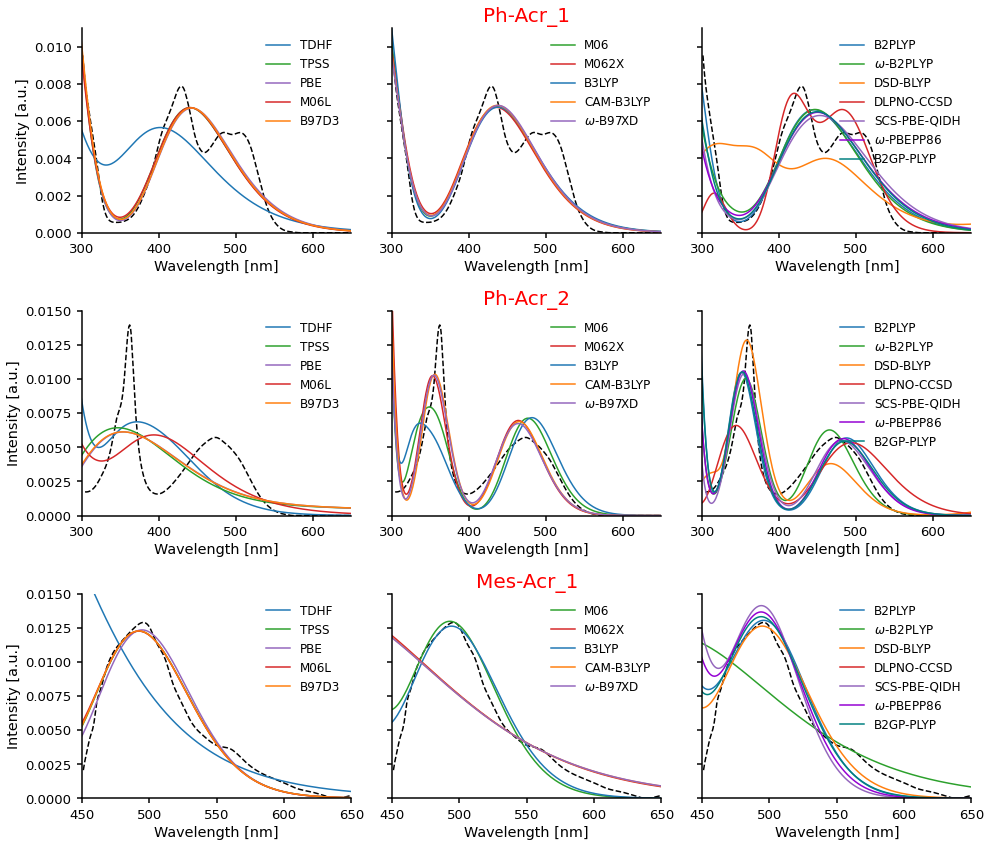

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,12), sharex="row", sharey="row")
#fig.subplots_adjust(hspace=0.3)

moleculesList = ['Ph-Acr_1', 'Ph-Acr_2', 'Mes-Acr_1']
for i, mol in enumerate(moleculesList):
  molecule = fulldb[fulldb['molecule'] == mol]
  expt = molecule[molecule['reference'] == 'yes']
  #pred = molecule[molecule['reference'] == 'no']
  mse_db = molecule[molecule['error_function'] == 'mse']
  mse_db1 = mse_db[mse_db['functional'].isin(func1)]
  mse_db2 = mse_db[mse_db['functional'].isin(func2)]
  mse_db3 = mse_db[mse_db['functional'].isin(func3)]

  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=func1).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=func2).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=func3).legend(frameon=False,fontsize='12',ncol=1)

  # title = f"-------------------------- {mol} -------------------------------"
  title = mol
  ax[i][1].set_title(title, c="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
  if mol == "Ph-Acr_1":
    ax[i][0].set_xlim(300,650) # x and y is shared over rows so only need to set it once per row
    ax[i][0].set_ylim(0,0.011)
  elif mol == "Ph-Acr_2":
    ax[i][0].set_xlim(300,650)
    ax[i][0].set_ylim(0,0.015)
  elif mol == "Mes-Acr_1":
    ax[i][0].set_xlim(450,650)
    ax[i][0].set_ylim(0,0.015)
    # start, end = ax[i][0].get_ylim()
    # ax[i][0].yaxis.set_ticks(np.arange(start, end, 0.004))


plt.tight_layout()
sns.despine()
plt.savefig('Ph-Mes-Acr_spectra.png', dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

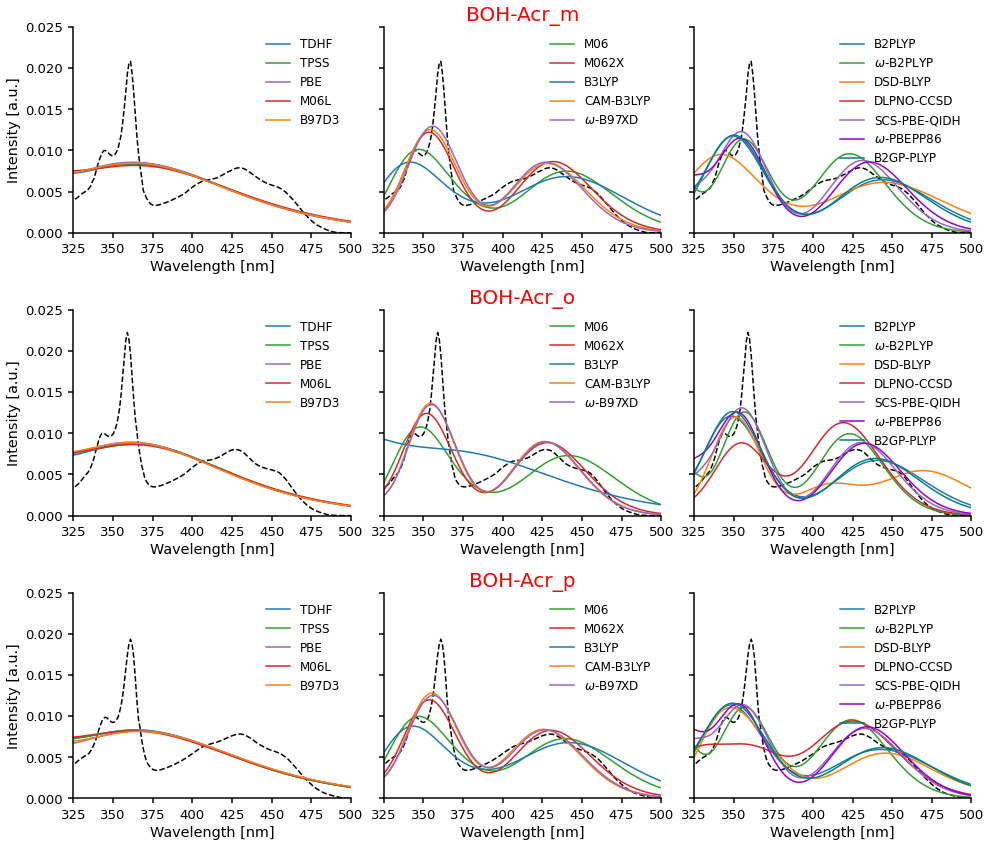

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,12), sharex="row", sharey="row")
#fig.subplots_adjust(hspace=0.3)

moleculesList = ['BOH-Acr_m', 'BOH-Acr_o', 'BOH-Acr_p']
for i, mol in enumerate(moleculesList):
  molecule = fulldb[fulldb['molecule'] == mol]
  expt = molecule[molecule['reference'] == 'yes']
  #pred = molecule[molecule['reference'] == 'no']
  mse_db = molecule[molecule['error_function'] == 'mse']
  mse_db1 = mse_db[mse_db['functional'].isin(func1)]
  mse_db2 = mse_db[mse_db['functional'].isin(func2)]
  mse_db3 = mse_db[mse_db['functional'].isin(func3)]

  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=func1).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=func2).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=func3).legend(frameon=False,fontsize='12',ncol=1)

  # title = f"-------------------------- {mol} -------------------------------"
  title = mol
  ax[i][1].set_title(title, c="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
  if mol == "BOH-Acr_m":
    ax[i][0].set_xlim(325,500) # x and y is shared over rows so only need to set it once per row
    ax[i][0].set_ylim(0,0.025)
  elif mol == "BOH-Acr_o":
    ax[i][0].set_xlim(325,500)
    ax[i][0].set_ylim(0,0.025)
  elif mol == "BOH-Acr_p":
    ax[i][0].set_xlim(325,500)
    ax[i][0].set_ylim(0,0.025)
    # start, end = ax[i][0].get_ylim()
    # ax[i][0].yaxis.set_ticks(np.arange(start, end, 0.004))


plt.tight_layout()
sns.despine()
plt.savefig('BOH-Acr_spectra.png', dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

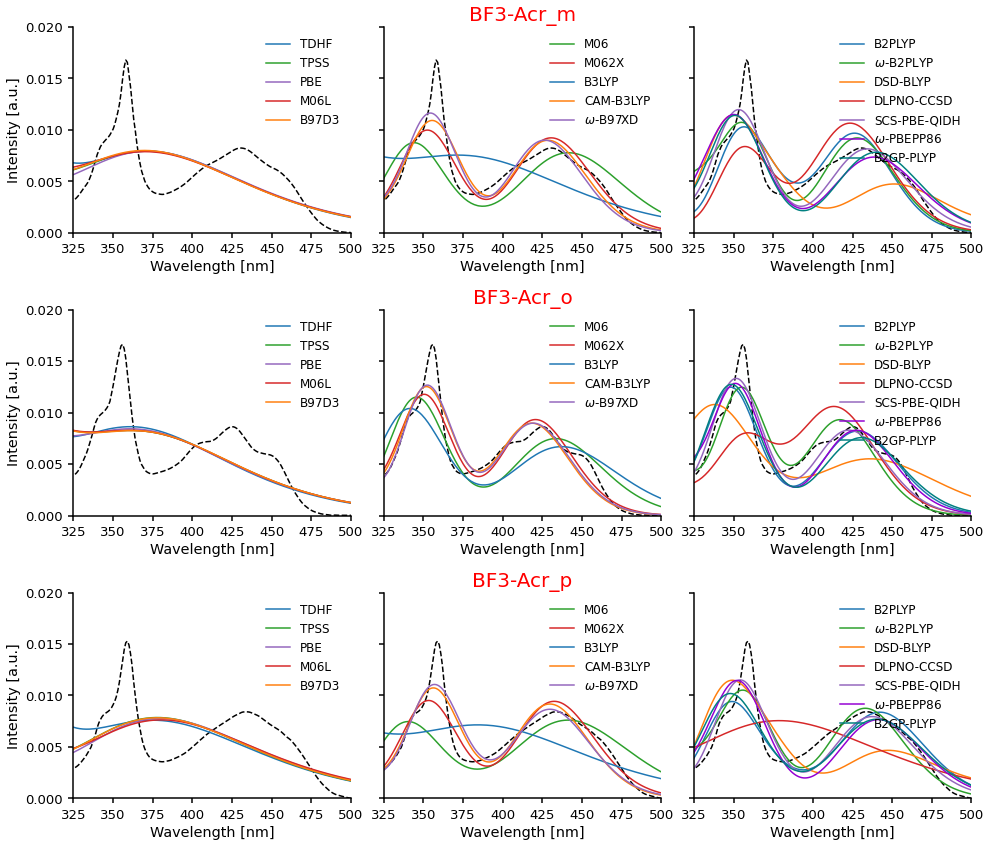

In [42]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,12), sharex="row", sharey="row")
#fig.subplots_adjust(hspace=0.3)

moleculesList = ['BF3-Acr_m', 'BF3-Acr_o', 'BF3-Acr_p']
for i, mol in enumerate(moleculesList):
  molecule = fulldb[fulldb['molecule'] == mol]
  expt = molecule[molecule['reference'] == 'yes']
  #pred = molecule[molecule['reference'] == 'no']
  mse_db = molecule[molecule['error_function'] == 'mse']
  mse_db1 = mse_db[mse_db['functional'].isin(func1)]
  mse_db2 = mse_db[mse_db['functional'].isin(func2)]
  mse_db3 = mse_db[mse_db['functional'].isin(func3)]

  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][0],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db1, hue="functional",palette=pal,hue_order=func1).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][1],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db2, hue="functional",palette=pal,hue_order=func2).legend(frameon=False,fontsize='12',ncol=1)

  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=expt, color="black", linestyle='--')
  sns.lineplot(ax=ax[i][2],x="Wavelength [nm]", y="Intensity [a.u.]", data=mse_db3, hue="functional",palette=pal,hue_order=func3).legend(frameon=False,fontsize='12',ncol=1)

  # title = f"-------------------------- {mol} -------------------------------"
  title = mol
  ax[i][1].set_title(title, c="red", fontsize= 20) # fontweight='bold', bbox=dict(facecolor='none', edgecolor='blue', pad=0.1, boxstyle='round')
  if mol == "BF3-Acr_m":
    ax[i][0].set_xlim(325,500) # x and y is shared over rows so only need to set it once per row
    ax[i][0].set_ylim(0,0.02)
  elif mol == "BF3-Acr_o":
    ax[i][0].set_xlim(325,500)
    ax[i][0].set_ylim(0,0.02)
  elif mol == "BF3-Acr_p":
    ax[i][0].set_xlim(325,500)
    ax[i][0].set_ylim(0,0.02)
    # start, end = ax[i][0].get_ylim()
    # ax[i][0].yaxis.set_ticks(np.arange(start, end, 0.004))


plt.tight_layout()
sns.despine()
plt.savefig('BF3-Acr_spectra.png', dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

In [43]:
import os
import shutil

files = os.listdir('.')
pngfiles = []
for i in files:
  if i[-4:] == '.png':
    pngfiles.append(i)

if not os.path.exists('images'):
  os.mkdir('images')

for i in pngfiles:
  shutil.copy2(i, 'images')

!zip -r '/content/images.zip' '/content/images'

  adding: content/images/ (stored 0%)
  adding: content/images/PA_spectra.png (deflated 3%)
  adding: content/images/Rh_spectra.png (deflated 3%)
  adding: content/images/POZ_spectra.png (deflated 3%)
  adding: content/images/3_regions_moltypes_3best.png (deflated 9%)
  adding: content/images/five_errors.png (deflated 17%)
  adding: content/images/3x3_spectra_different.png (deflated 4%)
  adding: content/images/NCE_spectra.png (deflated 4%)
  adding: content/images/BOH-Acr_spectra.png (deflated 4%)
  adding: content/images/2D_hist_R2.png (deflated 9%)
  adding: content/images/3_regions_moltypes_funcgroups.png (deflated 9%)
  adding: content/images/Ph-Mes-Acr_spectra.png (deflated 3%)
  adding: content/images/2D_hist_rmsle.png (deflated 9%)
  adding: content/images/2D_hist_pearson.png (deflated 9%)
  adding: content/images/PDI_spectra.png (deflated 3%)
  adding: content/images/CA_spectra.png (deflated 3%)
  adding: content/images/2D_hist.png (deflated 9%)
  adding: content/images/PTZ_sp

## Lowest lambda

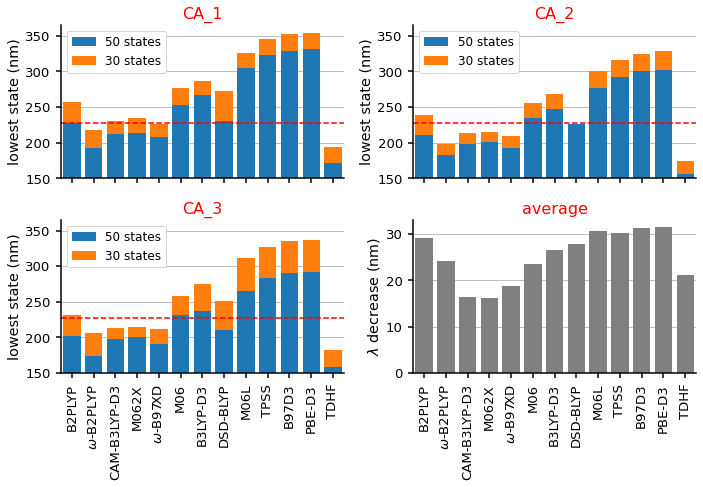

In [44]:
# lowestLambdas_ = get_lowestLambdas("lambda_abs_maxes_nStates30-50.xlsx")
lowestLambdas_ = get_lowestLambdas("/content/photocatalyst-TDDFT-benchmark/for_analysis/lambda_abs_maxes_nStates30-50.xlsx")  # if using Google Colab and git clone

avg_diff = lowestLambdas_.groupby("functional", as_index=False).mean()
# lowestLambdas = pd.melt(lowestLambdas_.drop(columns=["difference"]), id_vars=["molecule","functional"], value_vars=["30_states",	"50_states"], var_name="Nstates", value_name="lambda")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7), sharex=True, sharey=False)
axes = axes.flatten()
# plt.subplots_adjust(hspace=0.1) # not working?

molecules = lowestLambdas_.molecule.unique()
func_order_b = ['B2PLYP', '$\\omega$-B2PLYP', 'CAM-B3LYP-D3', 'M062X',
                '$\\omega$-B97XD', 'M06', 'B3LYP-D3', 
                'DSD-BLYP', 'M06L', 'TPSS', 'B97D3', 'PBE-D3', 'TDHF'] # ordered by mse error without CCSD

for i, ax in enumerate(axes):
  if i < 3:
    mol = molecules[i]
    mol_db = lowestLambdas_.query(f"molecule == '{mol}'")
    mol_db.set_index("functional").loc[func_order_b].plot(ax=ax, kind="bar", stacked=True, y=["50_states","difference"], width=0.8)
    ax.set_title(mol, color="red", fontsize=16)
    ax.legend(["50 states", "30 states"], frameon=True, title=None, fontsize=12, facecolor="white", framealpha=1, loc='upper left')
    ax.set_ylabel('lowest state (nm)')
    ax.set_ylim(150,365)
    ax.axhline(y=228, color="red", linestyle='--') # 229 nm should be set for CA_2, but the difference is barely visible
  else:
    sns.barplot(ax=ax, data=avg_diff, x="functional", y="difference", order=func_order_b, color="grey")
    # ax.get_legend().remove()
    ax.set_title('average', color="red", fontsize=16)
    ax.set_ylabel(r'$\lambda$ decrease (nm)')
  ax.set_xlabel(None)
  ax.grid(axis = 'y')
  ax.set_axisbelow(True)
  sns.despine()

plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()
plt.savefig('CA_minLambda_decrease.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

## Lowest lambda for all

In [45]:
# lowestLambdas = get_lowestLambdas("lambda_abs_mins.csv")
lowestLambdas = get_lowestLambdas("/content/photocatalyst-TDDFT-benchmark/for_analysis/lambda_abs_mins.csv") # if using Google Colab and git clone
lowestLambdas.replace({-5903.6: 240.4}, inplace=True) # replace the anomalous data in Eos_Y/DSD-BLYP with 2nd lowest lambda

In [46]:
np.sort(lowestLambdas.query("lambda_abs_min > 300").molecule.unique())

array(['CA_1', 'CA_2', 'Eos_1', 'Eos_2', 'Eos_3', 'Eos_Y', 'Me2-Acr_2',
       'NCE_4', 'PDI_2', 'PDI_3', 'POZ_1'], dtype=object)

In [47]:
order = ['B2PLYP', '$\\omega$-B2PLYP', 'CAM-B3LYP-D3', 'M062X',
         '$\\omega$-B97XD', 'M06', 'DLPNO-CCSD', 'B3LYP-D3', 'DSD-BLYP',
         'M06L', 'TPSS', 'B97D3', 'PBE-D3', 'TDHF'] # mse order

df_min = lowestLambdas.groupby("functional",as_index=False).min(numeric_only=True).rename(columns={"lambda_abs_min":"min"})
df_max = lowestLambdas.groupby("functional",as_index=False).max(numeric_only=True).rename(columns={"lambda_abs_min":"max"})
df_mean = lowestLambdas.groupby("functional",as_index=False).mean(numeric_only=True).rename(columns={"lambda_abs_min":"mean"})
# df_min.merge(df_max, how="outer").merge(df_mean, how="outer")
df = df_min.merge(df_max).merge(df_mean)
df["MinMaxDiff"] = df["max"] - df["min"]
df['functional'] = pd.Categorical(df['functional'],categories=order,ordered=True)
df.sort_values("functional", ignore_index=True, inplace=True)

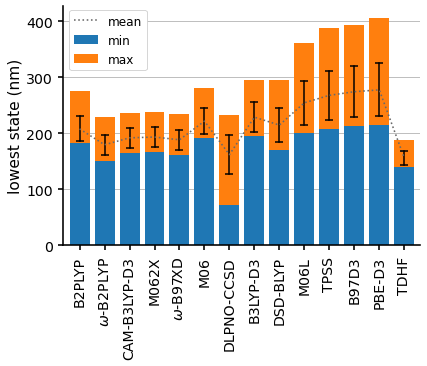

In [57]:
# run this cell twice if the bars do not appear on the plot
order = ['B2PLYP', '$\\omega$-B2PLYP', 'CAM-B3LYP-D3', 'M062X',
         '$\\omega$-B97XD', 'M06', 'DLPNO-CCSD', 'B3LYP-D3', 'DSD-BLYP',
         'M06L', 'TPSS', 'B97D3', 'PBE-D3', 'TDHF'] # mse order

# df.set_index("functional").loc[order].plot(ax=ax, kind="bar", stacked=True, y=["min","MinMaxDiff"], width=0.8).set_axisbelow(True)
ax = df.plot(ax=ax, kind="bar", stacked=True, x="functional",y=["min","MinMaxDiff"], width=0.8).set_axisbelow(True)

lowestLambdas_ = lowestLambdas.copy()
lowestLambdas_['functional'] = pd.Categorical(lowestLambdas_['functional'],categories=order,ordered=True)
sns.lineplot(ax=ax, data=lowestLambdas_, x="functional", y="lambda_abs_min",
             err_style="bars", estimator=np.mean, ci="sd", n_boot=1000,
             err_kws={"capsize":4, "elinewidth":1.5, "ecolor":'k', "capthick":1.5},
             color='dimgrey', ls=':').set_axisbelow(True)#.lines[0].set_linestyle(":")

plt.legend(["mean", "min", "max"], frameon=True, title=None, fontsize=12, facecolor="white", framealpha=1, loc='upper left', bbox_to_anchor=(0., 1.01))
plt.xlabel(None)
plt.ylabel('lowest state (nm)')
# plt.ylim(150,370)
plt.xticks(rotation=90)
plt.grid(axis = 'y')
sns.despine()
plt.savefig('LowestLambdas.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()
# run this cell twice if the bars do not appear on the plot

## Charge-transfer analysis

In [49]:
db = pd.read_csv("/content/photocatalyst-TDDFT-benchmark/for_analysis/CT_analysis.csv", header=0) # if using Google Colab and git clone
db

molecule    functional  state       E       f   delta_r
0      POZ_2  CAM-B3LYP-D3      1  3.7615  0.2440  2.494872
1      POZ_2  CAM-B3LYP-D3      2  4.1723  0.2710  1.917389
2      POZ_2  CAM-B3LYP-D3      3  4.4085  0.0021  3.840428
3      POZ_2  CAM-B3LYP-D3      4  4.4411  0.0236  2.077494
4      POZ_2  CAM-B3LYP-D3      5  4.8904  0.0329  1.715759
..       ...           ...    ...     ...     ...       ...
115    PDI_2  CAM-B3LYP-D3      6  4.2241  0.0001  0.012935
116    PDI_2  CAM-B3LYP-D3      7  4.2288  0.0001  0.013032
117    PDI_2  CAM-B3LYP-D3      8  4.2795  0.0000  0.032389
118    PDI_2  CAM-B3LYP-D3      9  4.3439  0.0012  0.014396
119    PDI_2  CAM-B3LYP-D3     10  4.6108  0.0064  0.003624

[120 rows x 6 columns]

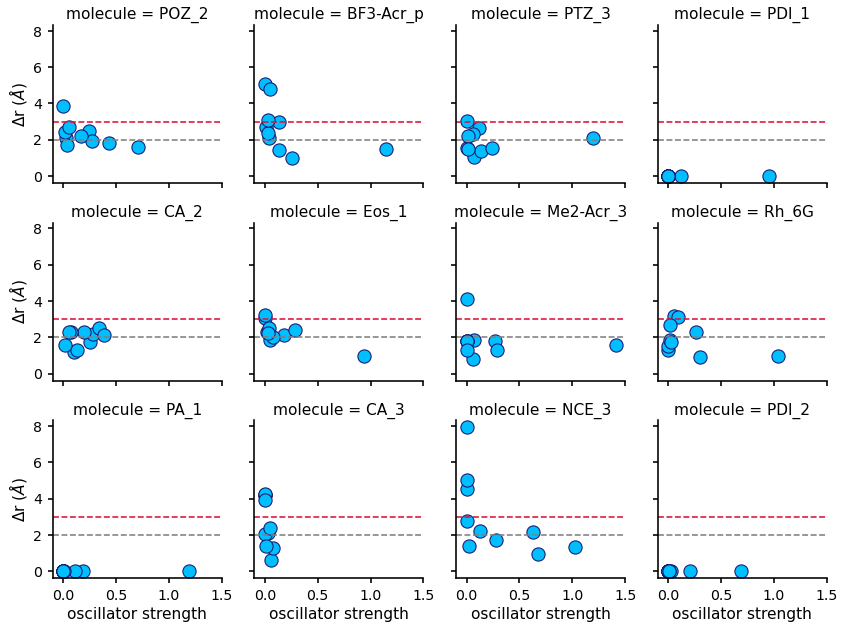

In [50]:
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.6
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

grid = sns.FacetGrid(data=db, col="molecule", col_wrap=4)
grid.refline(y=2.0, color='.5', linestyle='--')
grid.refline(y=3.0, color='crimson', linestyle='--')
grid.map(sns.scatterplot, "f", "delta_r", s=175, marker="o", facecolor='deepskyblue', edgecolor='midnightblue')
# grid.map(sns.scatterplot, "f", "delta_r", s=75, marker="x", linewidth=1.75, color='seagreen')

grid.set(xlabel="oscillator strength", ylabel=r"$\Delta$r ($\AA$)", xlim=(-0.1,1.5))
grid.tight_layout()

plt.savefig('CT_analysis.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

## Diffuse basis tests

In [51]:
diffuses = ["6-31+G**", "6-31++G**", "6-311+G**"]
non_diff = ["6-31G**", "def2-SVP", "def2-TZVP"]
w = ("6-31++G**", "def2-TZVP", "6-311+G**")

In [52]:
diffuse_db = pd.read_csv("/content/photocatalyst-TDDFT-benchmark/for_analysis/spectra_in_folder_200-700_nm.csv", header=0) # if using Google Colab and git clone

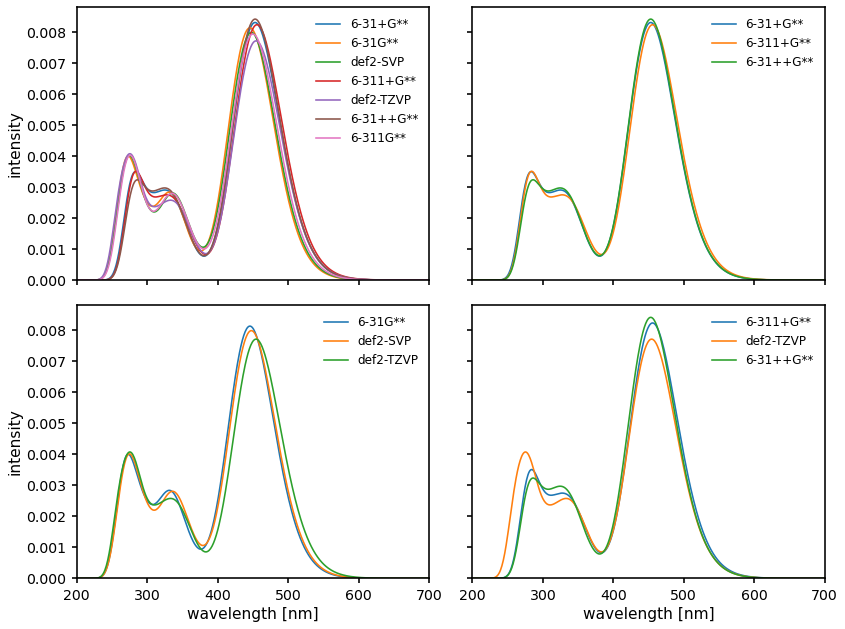

In [53]:
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.6
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9), sharex=True, sharey=True)
axes = axes.flatten()

g = sns.lineplot(ax=axes[0], data=diffuse_db, x="wavelength", y="intensity", hue="basis")
h = sns.lineplot(ax=axes[1], data=diffuse_db.query("basis in @diffuses"), x="wavelength", y="intensity", hue="basis")
i = sns.lineplot(ax=axes[2], data=diffuse_db.query("basis in @non_diff"), x="wavelength", y="intensity", hue="basis")
j = sns.lineplot(ax=axes[3], data=diffuse_db.query("basis in @w"), x="wavelength", y="intensity", hue="basis")

for ax in axes:
  ax.legend(title=None, fontsize=12, frameon=False)
  ax.set(xlabel="wavelength [nm]")

plt.xlim(200,700)
plt.ylim(0,0.0088)
plt.tight_layout()
plt.savefig('diffuse_bases.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()


## Additional code

In [54]:
# fulldb.groupby("functional").count() # check if we have all the data (note: not all calculations were done with CCSD)

Run the code below to get a zip file that contains all image files generated by the Notebook. It makes downloading them from Colab much easier.

In [55]:
# import os
# import shutil

# files = os.listdir('.')
# pngfiles = []
# for i in files:
#   if i[-4:] == '.png':
#     pngfiles.append(i)

# if not os.path.exists('images'):
#   os.mkdir('images')

# for i in pngfiles:
#   shutil.copy2(i, 'images')

# !zip -r '/content/images.zip' '/content/images'